In [1]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b1d790f7dbe15606a285b37d01334e4bb8316757514e89116fe327c76285198f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [2]:
# General Libraries
import os
import cv2
import copy
import math
import shutil
from tqdm import tqdm
from time import time
import datetime as dtime
from pprint import pprint
from sklearn.utils import shuffle
from datetime import datetime, timedelta
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn import BCEWithLogitsLoss
from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

In [3]:
train = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")

# Get image path
base_path = "/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_dicomsdl_512/train_images_processed_cv2_dicomsdl_512/"
''
all_paths = []
for k in tqdm(range(len(train))):
    row = train.iloc[k, :]
    all_paths.append(base_path + str(row.patient_id) + "/" + str(row.image_id) + ".png")
    
train["path"] = all_paths

display(train.head())

100%|██████████| 54706/54706 [00:05<00:00, 9541.66it/s]


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/...


In [7]:
def handle_directory(path, folder_name, erase=False):
    # Create the full path to the folder
    folder_path = os.path.join(path, folder_name)
    
    # Check if the folder exists
    if os.path.exists(folder_path):
        if erase:
            # If erase is True, delete the folder and its contents
            shutil.rmtree(folder_path)
            print(f"Folder '{folder_name}' at '{path}' has been erased.")
        else:
            print(f"Folder '{folder_name}' already exists and erase is set to False. No action taken.")
    else:
        print(f"Folder '{folder_name}' does not exist. Creating it now.")
    
    # Create the folder (this will happen after deletion if erase was True)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Folder '{folder_name}' has been created at '{path}'.")
    return folder_path

def extract_ids(path):
    # Split the path by slashes to extract parts
    parts = path.split('/')
    
    # The last two elements are id_patient and id_image
    id_patient = parts[-2]
    id_image = parts[-1].split('.')[0]  # Remove the file extension to get the id_image
    
    return id_patient, id_image

def fit_image(path_image, folder_path):
    # Reading the image using OpenCV
    X = cv2.imread(path_image)
    
    # Storing the original image for comparison
    original_image = X.copy()
    
    # Get the dimensions of the original image
    height_org, width_org, _ = original_image.shape

    # Cutting off the narrow exterior "frames"
    X = X[5:-5, 5:-5]

    # Creating a binary mask of non-empty pixels
    binary_mask = (X > 20).astype(np.uint8)[:, :, 0]

    # Finding connected components with statistics
    output = cv2.connectedComponentsWithStats(binary_mask, 8, cv2.CV_32S)

    # Extracting the statistics of the connected components
    stats = output[2]

    # Finding the largest area which is presumed to be the main data region
    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h

    # Cropping the image to the main data region
    X_fit = X[y1: y2, x1: x2]

    # Get the dimensions of the cropped image
    height_crop, width_crop = X_fit.shape[:2]

    patient_id, image_id = extract_ids(path_image)

    # Creating directory for the patient if it doesn't exist
    output_dir = os.path.join(folder_path, patient_id)
    os.makedirs(output_dir, exist_ok=True)

    # Saving the processed image
    output_path = os.path.join(output_dir, f'{image_id}.png')
    cv2.imwrite(output_path, X_fit[:, :, 0])
    
    return output_path, patient_id, image_id, (width_org, height_org), (width_crop, height_crop)

def fit_all_images(all_images, folder_path):
    data = []
    # Process each image sequentially
    for fname in tqdm(all_images, total=len(all_images)):
        output_dir, patient_id, image_id, dimensions_org, dimensions_crop = fit_image(fname, folder_path)
        data.append({
            'patient_id': patient_id,
            'image_id': image_id,
            'dimensions_org': dimensions_org,  # Store original dimensions as a tuple
            'dimensions_crop': dimensions_crop,  # Store cropped dimensions as a tuple
            'path_image_processed': output_dir
        })
    df = pd.DataFrame(data)
    return df

def handle_directory(base_path, folder_name, erase=False):
    """
    Handle the creation of the directory where the processed images will be saved.
    
    Parameters:
    base_path (str): The base directory path.
    folder_name (str): The name of the folder to be created or used.
    erase (bool): Whether to erase the folder if it already exists.
    
    Returns:
    str: The path to the directory where images will be saved.
    """
    folder_path = os.path.join(base_path, folder_name)
    
    if erase and os.path.exists(folder_path):
        # If the folder exists and erase flag is True, remove the folder and its contents
        shutil.rmtree(folder_path)
    
    # Create the directory if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)
    
    return folder_path

def process_images(train, kaggle_path, folder_name='Processed Image', flag_processed_image=False,erase=False):
    """
    Process images and save the results in a CSV file.

    Parameters:
    train (pd.DataFrame): DataFrame containing the paths to the images.
    kaggle_path (str): Base path for saving the processed images and CSV.
    folder_name (str): Name of the folder to save processed images. Default is 'Processed Image'.
    flag_processed_image (bool): Flag to process images if True, else load from CSV. Default is True.

    Returns:
    pd.DataFrame: DataFrame containing processed image data.
    """
    # Handle the directory where processed images will be saved
    path_processed_image = handle_directory(kaggle_path, folder_name, erase=erase)
    
    # Path to save the CSV file
    path_saved = os.path.join(kaggle_path, 'train_image_processed.csv')
    
    if flag_processed_image:
        # Extract paths of images to process
        path_images = train['path'].values.tolist() #[:10]
        # Process all images
        data_image = fit_all_images(path_images, path_processed_image)
        # Save the processed image data to CSV
        data_image.to_csv(path_saved, index=False)
        print(f"Dataframe saved to: {path_saved}")
    else:
        # Load processed image data from CSV
        data_image = pd.read_csv(path_saved)
    
    # Display the first few rows of the DataFrame
    display(data_image.head())
    
    return data_image

def merge_data(train, train_processed):
    print("Displaying the first few rows of the train dataset:")
    display(train.head())
    
    print("Displaying the data types of 'patient_id' and 'image_id' in the train dataset:")
    print(train[['patient_id', 'image_id']].dtypes)
    
    print("Displaying the first few rows of the train_processed dataset:")
    display(train_processed.head())
    
    print("Displaying the data types of 'patient_id' and 'image_id' in the train_processed dataset:")
    print(train_processed[['patient_id', 'image_id']].dtypes)
    
    print("Converting 'patient_id' and 'image_id' to int64 in the train_processed dataset...")
    train_processed['patient_id'] = train_processed['patient_id'].astype('int64')
    train_processed['image_id'] = train_processed['image_id'].astype('int64')

    print("Verifying the conversion of 'patient_id' and 'image_id' in the train_processed dataset:")
    print(train_processed[['patient_id', 'image_id']].dtypes)
    
    print("Merging the train and train_processed datasets on 'patient_id' and 'image_id' columns...")
    merged_df = pd.merge(train, train_processed, on=['patient_id', 'image_id'])
    
    print("Displaying the first few rows of the merged dataset:")
    display(merged_df.head())
    
    return merged_df


In [8]:
kaggle_path = '/kaggle/working/'
data_image = process_images(train, kaggle_path,flag_processed_image=True,erase=True)

100%|██████████| 54706/54706 [18:24<00:00, 49.52it/s]


Dataframe saved to: /kaggle/working/train_image_processed.csv


,patient_id,image_id,dimensions_org,dimensions_crop,path_image_processed
0,10006,462822612,"(512, 512)","(117, 318)",/kaggle/working/Processed Image/10006/46282261...
1,10006,1459541791,"(512, 512)","(136, 502)",/kaggle/working/Processed Image/10006/14595417...
2,10006,1864590858,"(512, 512)","(119, 381)",/kaggle/working/Processed Image/10006/18645908...
3,10006,1874946579,"(512, 512)","(107, 301)",/kaggle/working/Processed Image/10006/18749465...
4,10011,220375232,"(512, 512)","(224, 441)",/kaggle/working/Processed Image/10011/22037523...


In [9]:
data = merge_data(train, data_image)

Displaying the first few rows of the train dataset:


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/...


Displaying the data types of 'patient_id' and 'image_id' in the train dataset:
patient_id    int64
image_id      int64
dtype: object
Displaying the first few rows of the train_processed dataset:


,patient_id,image_id,dimensions_org,dimensions_crop,path_image_processed
0,10006,462822612,"(512, 512)","(117, 318)",/kaggle/working/Processed Image/10006/46282261...
1,10006,1459541791,"(512, 512)","(136, 502)",/kaggle/working/Processed Image/10006/14595417...
2,10006,1864590858,"(512, 512)","(119, 381)",/kaggle/working/Processed Image/10006/18645908...
3,10006,1874946579,"(512, 512)","(107, 301)",/kaggle/working/Processed Image/10006/18749465...
4,10011,220375232,"(512, 512)","(224, 441)",/kaggle/working/Processed Image/10011/22037523...


Displaying the data types of 'patient_id' and 'image_id' in the train_processed dataset:
patient_id    object
image_id      object
dtype: object
Converting 'patient_id' and 'image_id' to int64 in the train_processed dataset...
Verifying the conversion of 'patient_id' and 'image_id' in the train_processed dataset:
patient_id    int64
image_id      int64
dtype: object
Merging the train and train_processed datasets on 'patient_id' and 'image_id' columns...
Displaying the first few rows of the merged dataset:


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path,dimensions_org,dimensions_crop,path_image_processed
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(117, 318)",/kaggle/working/Processed Image/10006/46282261...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(136, 502)",/kaggle/working/Processed Image/10006/14595417...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(119, 381)",/kaggle/working/Processed Image/10006/18645908...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(107, 301)",/kaggle/working/Processed Image/10006/18749465...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(224, 441)",/kaggle/working/Processed Image/10011/22037523...


In [10]:
def prepare_data(data, kaggle_path):
    # Map the 'cancer' column to a new 'labels' column
    data['labels'] = data['cancer'].map({0: 'No Cancer', 1: 'Cancer'})
    print("Mapped 'cancer' column to 'labels' column.")

    # Check the number of missing values in the 'age' column before filling
    missing_before = data['age'].isnull().sum()
    print("Number of missing values in 'age' before filling:", missing_before)

    # Fill missing values in the 'age' column with 58
    data['age'] = data['age'].fillna(58)
    print("Filled missing values in 'age' column with 58.")

    # Check the number of missing values in the 'age' column after filling
    missing_after = data['age'].isnull().sum()
    print("Number of missing values in 'age' after filling:", missing_after)

    # Select specified columns
    features = ["patient_id", "image_id", "laterality", "view", "age", "implant", "cancer", "labels", "path_image_processed"]
    data = data[features]
    print("Selected specified columns.")
    
    data = tranform_categorical(data.copy())

    # Path to save the CSV file
    path_saved = os.path.join(kaggle_path, 'train_clean.csv')
    print(f"Path to save the CSV file: {path_saved}")

    # Save the cleaned data to CSV
    data.to_csv(path_saved, index=False)
    print("Saved the cleaned data to CSV.")

    return data

def tranform_categorical(data):
    """
    Encode categorical variables in the dataset.
    
    Parameters:
    - data: A pandas DataFrame containing the data with categorical variables 'laterality' and 'view'.
    
    Returns:
    - data: A pandas DataFrame with the categorical variables encoded as integers.
    """
    # Initialize LabelEncoders for categorical variables
    le_laterality = LabelEncoder()
    le_view = LabelEncoder()

    # Encode 'laterality' and 'view' columns
    data['laterality'] = le_laterality.fit_transform(data['laterality'])
    data['view'] = le_view.fit_transform(data['view'])

    return data

In [11]:
kaggle_path = '/kaggle/working/'
cleaned_data = prepare_data(data.copy(), kaggle_path)
display(cleaned_data)

Mapped 'cancer' column to 'labels' column.
Number of missing values in 'age' before filling: 37
Filled missing values in 'age' column with 58.
Number of missing values in 'age' after filling: 0
Selected specified columns.
Path to save the CSV file: /kaggle/working/train_clean.csv
Saved the cleaned data to CSV.


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,10006,462822612,0,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/46282261...
1,10006,1459541791,0,5,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/14595417...
2,10006,1864590858,1,5,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/18645908...
3,10006,1874946579,1,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/18749465...
4,10011,220375232,0,1,55.0,0,0,No Cancer,/kaggle/working/Processed Image/10011/22037523...
...,...,...,...,...,...,...,...,...,...
54701,9973,1729524723,1,5,43.0,0,0,No Cancer,/kaggle/working/Processed Image/9973/172952472...
54702,9989,63473691,0,5,60.0,0,0,No Cancer,/kaggle/working/Processed Image/9989/63473691.png
54703,9989,1078943060,0,1,60.0,0,0,No Cancer,/kaggle/working/Processed Image/9989/107894306...
54704,9989,398038886,1,5,60.0,0,0,No Cancer,/kaggle/working/Processed Image/9989/398038886...


In [12]:
def plot_label_distribution(train,dataset_type='Train'):
    """
    Plot the distribution of labels in the DataFrame `train`.

    Parameters:
    train (pd.DataFrame): DataFrame containing the label data.

    The DataFrame must have a column named 'labels'.
    """
    counts = train['labels'].value_counts()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # First subplot: bar chart
    bars = ax1.bar(counts.index, counts.values, color=sns.color_palette("pastel"))

    # Format the number with commas and display it above the bars
    for bar in bars:
        height = bar.get_height()
        percentage = (height / len(train)) * 100  # Calculate the percentage
        ax1.text(bar.get_x() + bar.get_width() / 2, height + (max(counts.values) * 0.02), 
                 f"{height:,.0f}\n({percentage:.1f}%)", ha='center', va='bottom', color='black', fontsize=10)

    #ax1.set_xlabel('Different types of labels in the Cancer column',loc='center')
    ax1.set_ylabel('Frequency')
    #ax1.set_title('Analysis of the target column Cancer', color='red')
    ax1.set_title(f'{dataset_type.capitalize()} Dataset: Analysis of the target column Cancer', color='red')

    # Show both horizontal and vertical grid lines
    ax1.grid(axis='both', linestyle='-', alpha=0.5)

    # Adjust y-limit to ensure text fits within the figure
    ax1.set_ylim(0, max(counts.values) * 1.2)

    # Second subplot: pie chart
    wedges, texts, autotexts = ax2.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90, 
                                       colors=sns.color_palette("pastel"), textprops=dict(color="w"))

    for text in texts:
        text.set_color('black')
    
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(10)
    
    #ax2.set_title('Distribution of labels', color='blue')
    ax2.set_title(f'{dataset_type.capitalize()} Dataset: Distribution of labels', color='red')

    # Adjust spacing between the two subplots
    plt.subplots_adjust(wspace=0.1)

    # Add a text box with the message
    message = f'The {dataset_type} dataset has {len(train)} samples with the following label distribution.'
    plt.figtext(0.5, 0.01, message, wrap=True, horizontalalignment='center', fontsize=11, color='black')

    plt.show()
    
def create_train_test_subsets(df, target_column, num_class_0_test, num_class_1_test):
    """
    This function takes a dataset and the name of a target column, selects a specific number of elements for each class (0 and 1)
    from the dataset for the test set. The function then determines how many samples should be in the training set
    to ensure there is no overlap and that all data is used.

    Args:
    - df (pd.DataFrame): The dataset to process.
    - target_column (str): The name of the target column.
    - num_class_0_test (int): The number of elements to select for class 0 in the test set.
    - num_class_1_test (int): The number of elements to select for class 1 in the test set.

    Returns:
    - pd.DataFrame: The training dataset.
    - pd.DataFrame: The test dataset.
    """
    
    # Separate the dataset into two subsets based on the target column value
    df_class_0 = df[df[target_column] == 0]
    df_class_1 = df[df[target_column] == 1]
    
    # Check if the requested number of test samples is available
    if num_class_0_test > len(df_class_0) or num_class_1_test > len(df_class_1):
        raise ValueError("Not enough samples available for the specified test set sizes.")
    
    # Select the samples for the test set
    df_class_0_test = df_class_0.sample(n=num_class_0_test, random_state=42).drop_duplicates()
    df_class_1_test = df_class_1.sample(n=num_class_1_test, random_state=42).drop_duplicates()
    
    # Determine the number of samples for the training set
    df_class_0_train = df_class_0.drop(df_class_0_test.index)
    df_class_1_train = df_class_1.drop(df_class_1_test.index)
    
    # Combine the training samples for both classes
    df_train = pd.concat([df_class_0_train, df_class_1_train]).reset_index(drop=True)
    
    # Combine the test samples for both classes
    df_test = pd.concat([df_class_0_test, df_class_1_test]).reset_index(drop=True)
    
    # Shuffle the rows of the training and test datasets
    df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
    df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df_train, df_test

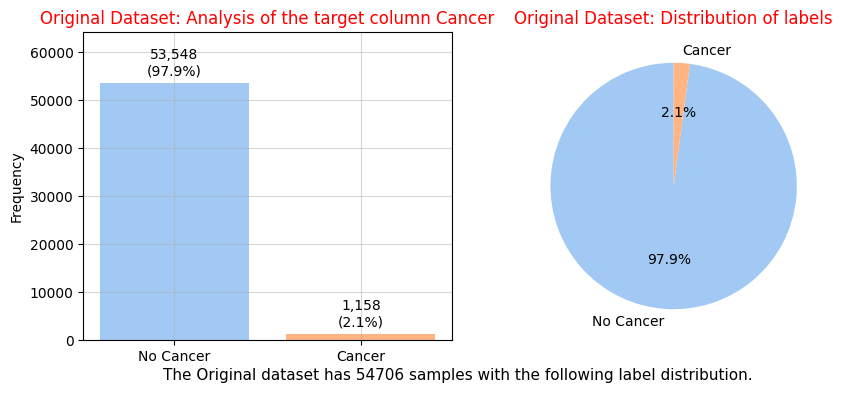

In [13]:
plot_label_distribution(cleaned_data,'Original')

In [14]:
factor_1 = 0.088
factor_0 = 0.20
org_dim_1 = cleaned_data[cleaned_data['cancer'] == 1].shape[0] # cancer
org_dim_0 = cleaned_data[cleaned_data['cancer'] == 0].shape[0] # no cancer
new_dim_1 = int(org_dim_1*factor_1)
new_dim_0 = int(org_dim_0*factor_0)
print(f'Number of sample of class 1 (cancer) {new_dim_1}')
print(f'Number of sample of class 0 (no cancer) {new_dim_0}')
no_sample_test_0, no_sample_test_1 = new_dim_0, new_dim_1
df_train, df_test = df_train, df_test = create_train_test_subsets(cleaned_data, 'cancer', no_sample_test_0, no_sample_test_1)
display("Train set: ", df_train.head())
display("Test set: ", df_test.head())

Number of sample of class 1 (cancer) 101
Number of sample of class 0 (no cancer) 10709


'Train set: '

,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,54072,560286389,0,5,57.0,0,0,No Cancer,/kaggle/working/Processed Image/54072/56028638...
1,6186,894777767,1,5,77.0,0,0,No Cancer,/kaggle/working/Processed Image/6186/894777767...
2,62284,1665854281,1,1,45.0,0,0,No Cancer,/kaggle/working/Processed Image/62284/16658542...
3,972,1729245851,0,1,48.0,0,0,No Cancer,/kaggle/working/Processed Image/972/1729245851...
4,35134,854124137,1,5,69.0,0,0,No Cancer,/kaggle/working/Processed Image/35134/85412413...


'Test set: '

,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,45986,1324153921,1,1,62.0,0,0,No Cancer,/kaggle/working/Processed Image/45986/13241539...
1,16580,951780220,1,5,68.0,0,0,No Cancer,/kaggle/working/Processed Image/16580/95178022...
2,7545,1675539843,1,5,87.0,0,0,No Cancer,/kaggle/working/Processed Image/7545/167553984...
3,53368,1374787150,0,1,84.0,0,0,No Cancer,/kaggle/working/Processed Image/53368/13747871...
4,20022,1808928918,1,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/20022/18089289...


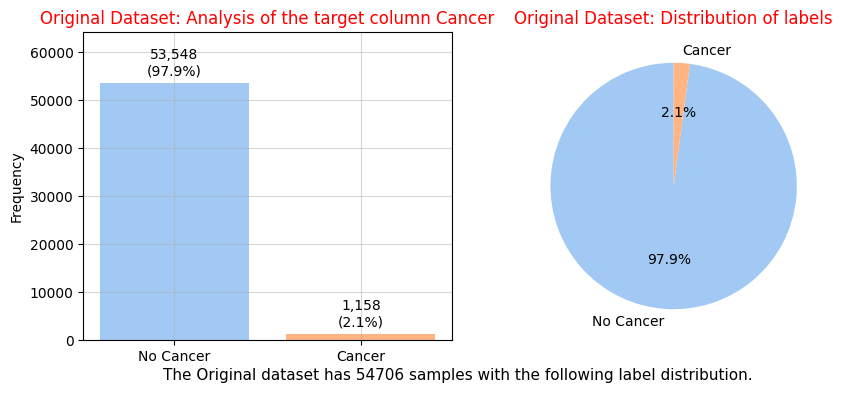

In [15]:
plot_label_distribution(cleaned_data,'Original')

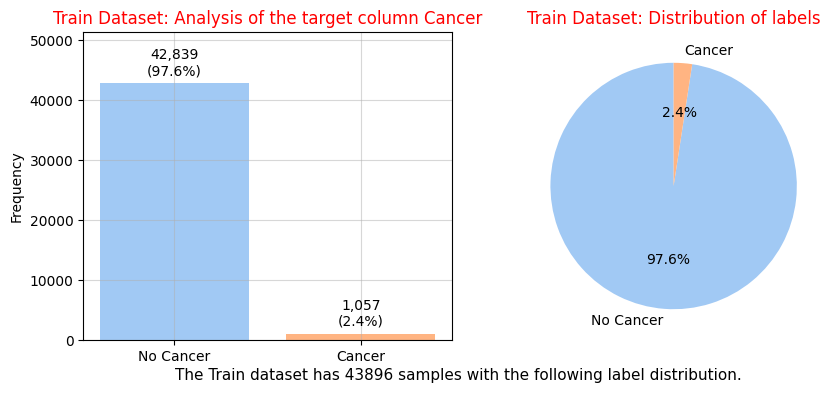

In [16]:
plot_label_distribution(df_train,'Train')

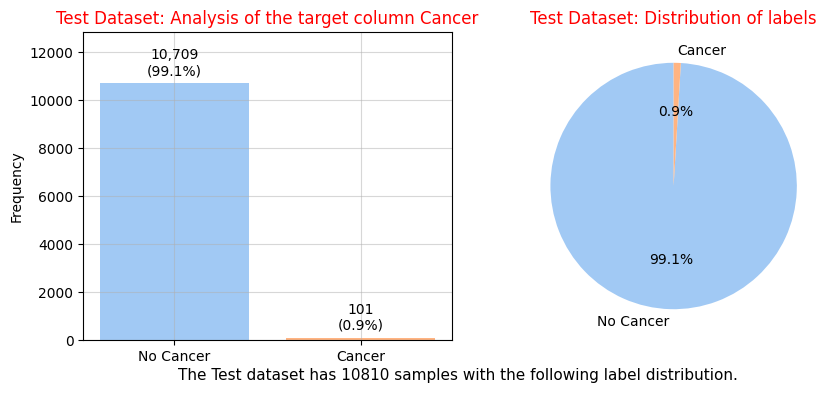

In [17]:
plot_label_distribution(df_test,'Test')

Size of cleaned data: 54706
Size of training data: 43896
Size of test data: 10810


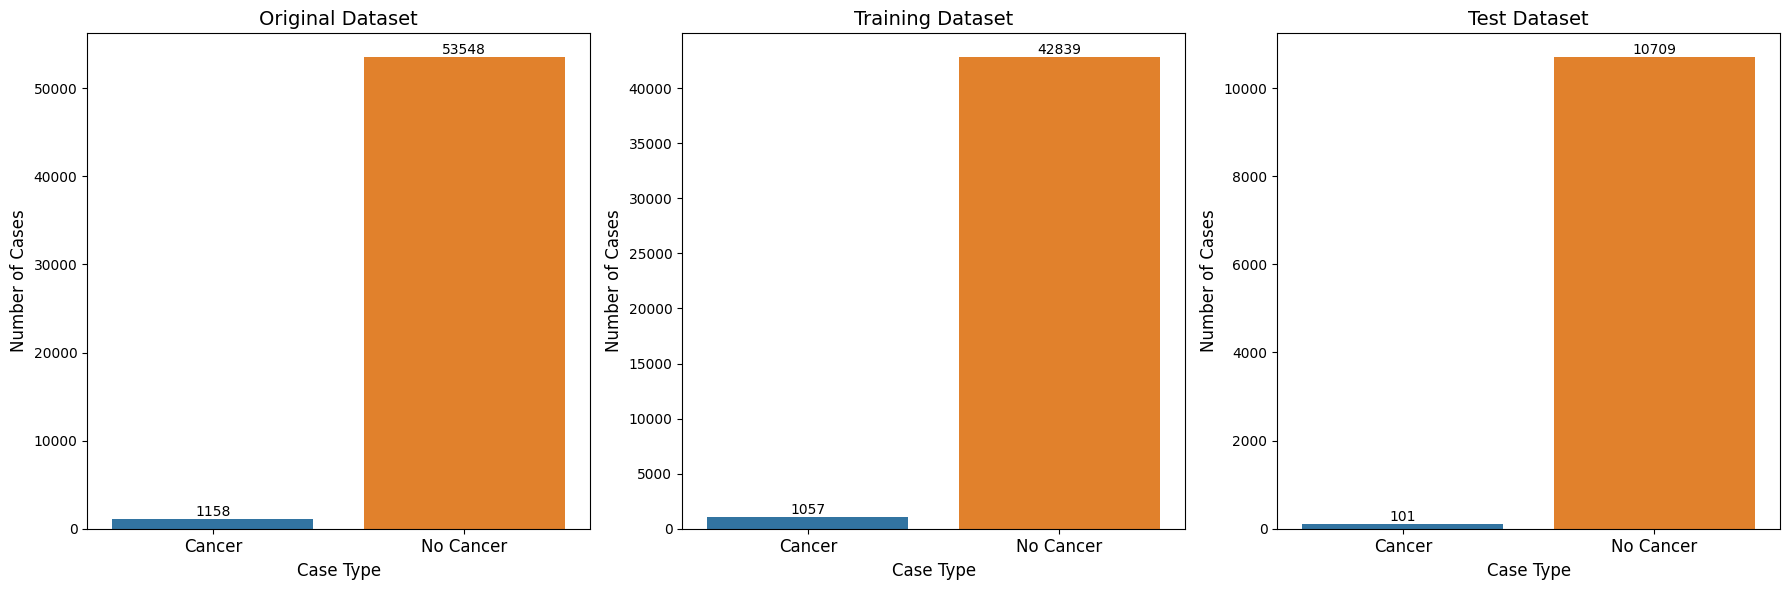

In [18]:
def plot_cases_count(df, title, ax):
    """
    Plot the count of each case type in the given DataFrame.
    
    Parameters:
    - df: DataFrame containing the data.
    - title: Title for the plot.
    - ax: Matplotlib axis object where the plot will be drawn.
    """
    # Count the number of occurrences for each label and sort by index
    cases_count = df['labels'].value_counts().sort_index()

    # Create a bar plot with a custom color palette
    palette = sns.color_palette(["#1f77b4", "#ff7f0e"])  # Custom colors: blue and orange
    sns.barplot(x=cases_count.index, y=cases_count.values, ax=ax, palette=palette)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Case Type', fontsize=12)
    ax.set_ylabel('Number of Cases', fontsize=12)
    ax.set_xticks(range(len(cases_count.index)))
    ax.set_xticklabels(cases_count.index, fontsize=12)
    
    # Add annotations for each bar
    for i, count in enumerate(cases_count.values):
        ax.text(i, count, f'{count}', ha='center', va='bottom', fontsize=10, color='black')

# Check the sizes of the datasets
print(f'Size of cleaned data: {len(cleaned_data)}')
print(f'Size of training data: {len(df_train)}')
print(f'Size of test data: {len(df_test)}')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Original data
plot_cases_count(cleaned_data, 'Original Dataset', axes[0])

# Plot for Training data
plot_cases_count(df_train, 'Training Dataset', axes[1])

# Plot for Test data
plot_cases_count(df_test, 'Test Dataset', axes[2])

plt.tight_layout()
plt.show()


In [19]:
1057*30

31710

In [20]:
def create_subset_train(df, target_column, num_class_0, num_class_1):
    """
    Cette fonction prend un ensemble de données et le nom d'une colonne cible, sélectionne un nombre spécifique
    d'éléments pour chaque valeur de la colonne cible (0 et 1), puis fusionne ces sous-ensembles en un seul
    ensemble de données.

    Args:
    - df (pd.DataFrame): L'ensemble de données à traiter.
    - target_column (str): Le nom de la colonne cible.
    - num_class_0 (int): Le nombre d'éléments à sélectionner pour la classe 0.
    - num_class_1 (int): Le nombre d'éléments à sélectionner pour la classe 1.

    Returns:
    - pd.DataFrame: L'ensemble de données fusionné contenant des sous-ensembles équilibrés.
    """
    
    # Séparer l'ensemble de données en deux sous-ensembles en fonction de la valeur de la colonne cible
    df_class_0 = df[df[target_column] == 0]
    df_class_1 = df[df[target_column] == 1]
    
    # Sélectionner un échantillon de taille num_class_0 à partir du sous-ensemble de la classe 0 sans répétition
    df_class_0_sample = df_class_0.sample(n=num_class_0, random_state=42).drop_duplicates()
    
    # Sélectionner un échantillon de taille num_class_1 à partir du sous-ensemble de la classe 1 sans répétition
    df_class_1_sample = df_class_1.sample(n=num_class_1, random_state=42).drop_duplicates()
    
    # Fusionner les deux échantillons en un seul ensemble de données
    df_sample = pd.concat([df_class_0_sample, df_class_1_sample]).reset_index(drop=True)
    
    # Mélanger les lignes de l'ensemble de données résultant
    df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df_sample

In [21]:
# Function to manage directories
def manage_directories(create_dirs: bool):
    base_dir = '/kaggle/working/data_augmentation_image'
    cancer_dir = os.path.join(base_dir, 'cancer')
    no_cancer_dir = os.path.join(base_dir, 'no_cancer')
    
    if create_dirs:
        if os.path.exists(base_dir):
            print(f"Base directory '{base_dir}' already exists. Removing it.")
            shutil.rmtree(base_dir)
            print(f"Base directory '{base_dir}' has been removed.")
        
        print(f"Creating directories '{cancer_dir}' and '{no_cancer_dir}'.")
        os.makedirs(cancer_dir)
        os.makedirs(no_cancer_dir)
        print(f"Directories '{cancer_dir}' and '{no_cancer_dir}' have been created.")
        
    else:
        if not os.path.exists(base_dir):
            print(f"Base directory '{base_dir}' does not exist. Creating it along with subdirectories.")
            os.makedirs(cancer_dir)
            os.makedirs(no_cancer_dir)
            print(f"Directories '{cancer_dir}' and '{no_cancer_dir}' have been created.")
        else:
            print(f"Base directory '{base_dir}' already exists. No action taken.")

In [22]:
manage_directories(create_dirs=True)

Creating directories '/kaggle/working/data_augmentation_image/cancer' and '/kaggle/working/data_augmentation_image/no_cancer'.
Directories '/kaggle/working/data_augmentation_image/cancer' and '/kaggle/working/data_augmentation_image/no_cancer' have been created.


In [25]:
# Fonction pour générer l'ID de l'image traitée
def generate_image_processed_id(image_id, index):
    return f"{image_id}_aug_{index}"

# Fonction pour appliquer les transformations et sauvegarder les images transformées
def apply_transformations_and_save(path_cancer: str, path_no_cancer: str, Width: int, Height: int, num_images_cancer: int, dataset: pd.DataFrame, transformations_cancer):
    resize_transform = A.Resize(width=Width, height=Height)

    # Initialiser les compteurs
    num_rejected,num_accepted,num_cancer,num_no_cancer = 0,0,0,0

    processed_data = []

    for index, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
        image_path,image_id,is_cancer = row['path_image_processed'],row['image_id'],row['cancer']

        # Lire l'image avec OpenCV et convertir en RGB
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: could not read image {image_path}. Skipping.")
            num_rejected += 1
            continue

        # Redimensionner l'image
        image_resized = resize_transform(image=image)['image']
        image_resized = cv2.cvtColor(image_resized, cv2.COLOR_RGB2BGR)
        image_resized_id = f"{image_id}_resized"
        if is_cancer == 0:
            save_folder = path_no_cancer
            num_no_cancer += 1
        else:
            save_folder = path_cancer
            num_cancer += 1
        save_path_resized = os.path.join(save_folder, f"{image_resized_id}.png")
        cv2.imwrite(save_path_resized, image_resized)

        processed_data.append({
            'patient_id': row['patient_id'],'image_id': image_id,'image_processed_id': image_resized_id,
            'laterality': row['laterality'],'view': row['view'],'age': row['age'],'cancer': is_cancer,
            'labels': row['labels'],'implant': row['implant'],'path_img_aug': save_path_resized
            })

        if is_cancer == 1: 
            transformations = transformations_cancer
            num_processed = num_images_cancer
            #print("Image to process:",num_processed)
            for i in range(num_processed):
                transformed = transformations[i](image=image_resized)['image']
                transformed = cv2.cvtColor(transformed, cv2.COLOR_RGB2BGR)
                image_processed_id = generate_image_processed_id(image_id, i)
                save_path = os.path.join(save_folder, f"{image_processed_id}.png")
                cv2.imwrite(save_path, transformed)
                processed_data.append({
                    'patient_id': row['patient_id'],
                    'image_id': image_id,
                    'image_processed_id': image_processed_id,
                    'laterality': row['laterality'],
                    'view': row['view'],
                    'age': row['age'],
                    'cancer': is_cancer,
                    'labels': row['labels'],
                    'implant': row['implant'],
                    'path_img_aug': save_path
                })
                num_cancer += 1
        #print("Len Image to process:",len(processed_data))
        num_accepted += 1

    print(f"Images rejectd: {num_rejected}")
    print(f"Images accepted: {num_accepted}")
    print(f"Images generated for cancer class: {num_cancer}")
    print(f"Images generated for no cancer class: {num_no_cancer}")

    processed_df = pd.DataFrame(processed_data)

    return processed_df


In [26]:
# Sample down for dev
num_class_0,num_class_1 = 4500,1057 #7000, 1057 # full dataset ===> 1500, 1158
sample_train = create_subset_train(df_train, 'cancer', num_class_0=num_class_0, num_class_1=num_class_1)
print(f'Shape Of Train Sample: {sample_train.shape}')
display(sample_train.head())
print("======="*20)

Shape Of Train Sample: (5557, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,34987,562433892,0,1,72.0,0,1,Cancer,/kaggle/working/Processed Image/34987/56243389...
1,3021,758579205,0,1,56.0,0,1,Cancer,/kaggle/working/Processed Image/3021/758579205...
2,263,2040961510,0,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/263/2040961510...
3,47556,677645230,1,5,58.0,0,0,No Cancer,/kaggle/working/Processed Image/47556/67764523...
4,22915,70293834,1,5,56.0,0,0,No Cancer,/kaggle/working/Processed Image/22915/70293834...


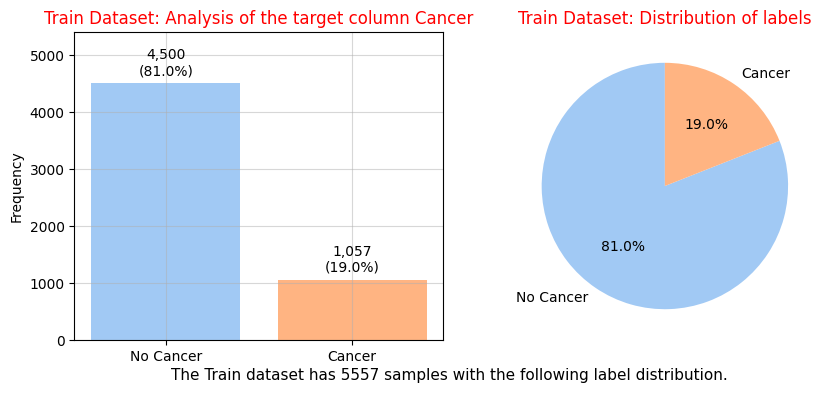

In [27]:
plot_label_distribution(sample_train,'Train')

In [24]:
1057*5

5285

In [28]:
Width, Height = 224, 224

# Define simple transformations for testing
transformations_cancer = [
    A.Compose([A.Resize(Width, Height), A.HorizontalFlip(p=0.78), A.VerticalFlip(p=0.89), A.RandomRotate90(p=1), A.Transpose(p=1)]),
    A.Compose([A.Resize(Width, Height), A.Rotate(limit=90, p=0.8), A.Perspective(scale=(0.05, 0.1), p=0.5)]),
    A.Compose([A.Resize(Width, Height), A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5), A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5)]),
    A.Compose([A.Resize(Width, Height), A.HorizontalFlip(p=0.78), A.VerticalFlip(p=0.89)]),
    #A.Compose([A.Resize(Width, Height), A.RandomRotate90(p=0.3), A.Transpose(p=0.8)]),
    #A.Compose([A.Resize(Width, Height), A.CLAHE(clip_limit=3, p=0.5), A.Sharpen(p=0.45), A.Emboss(p=0.78)]),
    #A.Compose([A.Resize(Width, Height), A.RandomRotate90(p=0.5),A.Transpose(p=0.5),A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
    #A.Compose([A.Resize(Width, Height), A.RandomCrop(height=200, width=200, p=0.5), A.Resize(Width, Height, p=1.0)]),
    #A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7)]),
    #A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)]),
    #A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5)])
]

# Test the function
processed_df = apply_transformations_and_save(
    '/kaggle/working/data_augmentation_image/cancer',
    '/kaggle/working/data_augmentation_image/no_cancer',
    Width=Width, 
    Height=Height, 
    num_images_cancer=len(transformations_cancer), 
    dataset=sample_train, 
    transformations_cancer=transformations_cancer)

# Display the processed DataFrame
display(processed_df)

100%|██████████| 5557/5557 [00:37<00:00, 147.04it/s]


Images rejectd: 0
Images accepted: 5557
Images generated for cancer class: 5285
Images generated for no cancer class: 4500


,patient_id,image_id,image_processed_id,laterality,view,age,cancer,labels,implant,path_img_aug
0,34987,562433892,562433892_resized,0,1,72.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
1,34987,562433892,562433892_aug_0,0,1,72.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
2,34987,562433892,562433892_aug_1,0,1,72.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
3,34987,562433892,562433892_aug_2,0,1,72.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
4,34987,562433892,562433892_aug_3,0,1,72.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
...,...,...,...,...,...,...,...,...,...,...
9780,6654,1497844117,1497844117_aug_0,1,1,50.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
9781,6654,1497844117,1497844117_aug_1,1,1,50.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
9782,6654,1497844117,1497844117_aug_2,1,1,50.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...
9783,6654,1497844117,1497844117_aug_3,1,1,50.0,1,Cancer,0,/kaggle/working/data_augmentation_image/cancer...


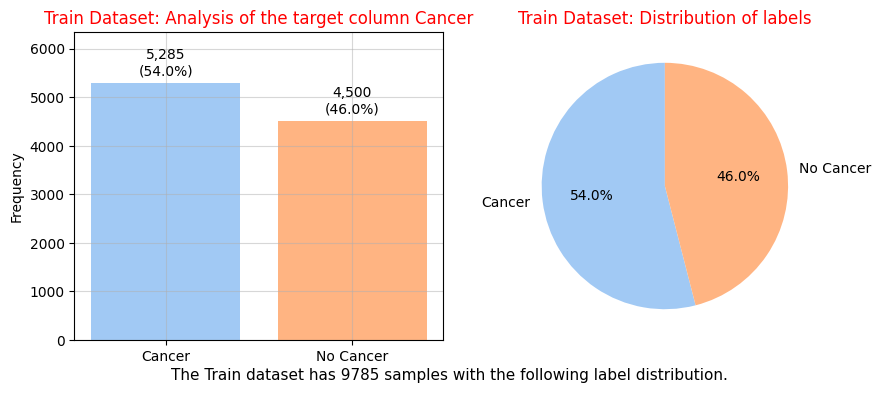

In [29]:
plot_label_distribution(processed_df,'Train')

In [30]:
# PyTorch
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize, RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise, Rotate, RandomResizedCrop, ShiftScaleRotate, ToGray)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='albumentations')

import logging
logging.getLogger('albumentations').setLevel(logging.ERROR)

# Custom colors
class Color:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'


class CustomRSNADataset(Dataset):
    
    def __init__(self, dataframe,csv_columns,is_train=True):
        self.dataframe, self.is_train,self.csv_columns  = dataframe, is_train, csv_columns
        
        # Data Augmentation (custom for each dataset type)
        self.transform = Compose([ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        '''Take each row in batch at a time.'''
        # print("Take each row in batch at a time.")
        # Select path and read image
        image_path = self.dataframe['path_img_aug'][index]
        image=cv2.imread(image_path).astype(np.float32)/255

        # Apply transforms
        transf_image = self.transform(image=image)['image']

        # For this image also import .csv information
        csv_data = np.array(self.dataframe.iloc[index][self.csv_columns].values,dtype=np.float32)

        #print(f'Type of transform Image Processed: {type(transf_image)}')  # Printing the type of the processed image
        #print(f'Type of csv_data: {type(csv_data)}')  # Printing the type of the processed image

        # Return info
        if self.is_train:
            return {"image": transf_image,"meta": csv_data,"target": self.dataframe['cancer'][index]}
        else:
            return {"image": transf_image,"meta": csv_data}

In [31]:
def set_seed(seed=42):
    """
    Set the seed for generating random numbers.
    
    Args:
        seed (int): The seed to use for the random number generators.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def data_to_device(data):
    """
    Transfer data to the specified device (e.g., CPU or GPU).

    Args:
    data (tuple): A tuple containing the data components to be transferred to the device.
                  Typically, it consists of image, metadata, and targets.

    Returns:
    tuple: A tuple containing the transferred data components, now residing on the specified device.
    """
    # Extract components from the input tuple
    image, metadata, targets = data.values()
    
    # Transfer each component to the specified device
    return image.to(DEVICE), metadata.to(DEVICE), targets.to(DEVICE)

In [32]:
# ----- GLOBAL PARAMS ------
csv_columns = ['laterality', 'view', 'age', 'implant']
no_columns = len(csv_columns)
output_size = 1
# --------------------------
# Use the set_seed function to initialize the seed
set_seed()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', DEVICE)

Device available now: cuda


In [33]:
# Sample data
sample = processed_df.head(10)

# Instantiate Dataset object
dataset = CustomRSNADataset(sample,csv_columns,is_train=True)

# The Dataloader
dataloader = DataLoader(dataset, batch_size=5, shuffle=False,num_workers=4)

# Output of the Dataloader
for k, data in enumerate(dataloader):
    image, meta, targets = data_to_device(data)
    print(Color.S + f"Batch: {k}" + Color.E, "\n" + Color.S + "Image:" + Color.E, image.shape, "\n" + Color.S + "Meta:" + Color.E, meta, "\n" + Color.S + "Targets:" + Color.E, targets, "\n" + "="*50)

Batch: 0 
Image: torch.Size([5, 3, 224, 224]) 
Meta: tensor([[ 0.,  1., 72.,  0.],
        [ 0.,  1., 72.,  0.],
        [ 0.,  1., 72.,  0.],
        [ 0.,  1., 72.,  0.],
        [ 0.,  1., 72.,  0.]], device='cuda:0') 
Targets: tensor([1, 1, 1, 1, 1], device='cuda:0') 
Batch: 1 
Image: torch.Size([5, 3, 224, 224]) 
Meta: tensor([[ 0.,  1., 56.,  0.],
        [ 0.,  1., 56.,  0.],
        [ 0.,  1., 56.,  0.],
        [ 0.,  1., 56.,  0.],
        [ 0.,  1., 56.,  0.]], device='cuda:0') 
Targets: tensor([1, 1, 1, 1, 1], device='cuda:0') 


In [34]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=(1,1), gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, preds, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(torch.flatten(preds), torch.flatten(targets).float())
        logits=nn.Sigmoid()(preds)
        F_loss = (self.alpha[0]*(targets)*((1-logits)**self.gamma)+ self.alpha[1]*(1-targets)*((logits)**self.gamma)) * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [35]:
class EffNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = EfficientNet.from_pretrained('efficientnet-b2')
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(1408 + 250, self.output_size))
        
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features.extract_features(image)
        image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out

In [36]:
# Load Model
EffNetNet_model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Explanation:
# This line creates an instance of an EfficientNet-based neural network model called 'model_example2'
# and transfers it to the specified device (e.g., CPU or GPU) using the '.to(DEVICE)' method.

# Outputs
out = EffNetNet_model(image, meta, prints=True)

# Explanation:
# This line passes input data (image and metadata) through the 'model_example2' neural network model,
# producing output predictions ('out'). If 'prints' is set to True, additional information may be printed
# during the forward pass of the model.

# Criterion example
#criterion_example = nn.BCEWithLogitsLoss()
criterion_example =FocalLoss(alpha=(50,1))

# Explanation:
# This line creates an instance of the Binary Cross-Entropy (BCE) loss function called 'criterion_example',
# which is commonly used for binary classification tasks. 

# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, targets.unsqueeze(1).float()) 

# Explanation:
# This line calculates the loss value by comparing the model predictions ('out') with the target labels ('targets').
# Before applying the loss function, the target labels are unsqueezed along dimension 1 using 'unsqueeze(1)' 
# to match the shape of the model predictions. The target labels are also converted to float using '.float()'
# to ensure compatibility with the model predictions.

print("="*50)
print(Color.S+'Loss:'+Color.E, loss.item())

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 234MB/s]


Loaded pretrained weights for efficientnet-b2
Input Image shape: torch.Size([5, 3, 224, 224]) 
Input metadata shape: torch.Size([5, 4])
Features Image shape: torch.Size([5, 1408])
Meta Data: torch.Size([5, 250])
Concatenated Data: torch.Size([5, 1658])
Out shape: torch.Size([5, 1])
Loss: 9.084547996520996


In [37]:
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = resnet50(pretrained=True) # 1000 neurons out
        # (metadata)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Linear(1000 + 500, output_size)
        
        
    def forward(self, image, meta, prints=False):
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out

In [39]:
# Load Model
ResNet50_model = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Explanation:
# This line creates an instance of an EfficientNet-based neural network model called 'model_example2'
# and transfers it to the specified device (e.g., CPU or GPU) using the '.to(DEVICE)' method.

# Outputs
out = ResNet50_model(image, meta, prints=True)

# Explanation:
# This line passes input data (image and metadata) through the 'model_example2' neural network model,
# producing output predictions ('out'). If 'prints' is set to True, additional information may be printed
# during the forward pass of the model.

# Criterion example
#criterion_example = nn.BCEWithLogitsLoss()
criterion_example = FocalLoss(alpha=(50,1))

# Explanation:
# This line creates an instance of the Binary Cross-Entropy (BCE) loss function called 'criterion_example',
# which is commonly used for binary classification tasks. 

# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, targets.unsqueeze(1).float()) 

# Explanation:
# This line calculates the loss value by comparing the model predictions ('out') with the target labels ('targets').
# Before applying the loss function, the target labels are unsqueezed along dimension 1 using 'unsqueeze(1)' 
# to match the shape of the model predictions. The target labels are also converted to float using '.float()'
# to ensure compatibility with the model predictions.

print("="*50)
print(Color.S+'Loss:'+Color.E, loss.item())

Input Image shape: torch.Size([5, 3, 224, 224]) 
Input metadata shape: torch.Size([5, 4])
Features Image shape: torch.Size([5, 1000])
Meta Data: torch.Size([5, 500])
Concatenated Data: torch.Size([5, 1500])
Out shape: torch.Size([5, 1])
Loss: 10.642603874206543


In [40]:
# General Libraries
import os
import re
import gc
import cv2
import copy
import shutil

def create_or_recreate_folder(base_path, folder_name):
    folder_path = os.path.join(base_path, folder_name)
    
    # Check if the folder exists
    if os.path.exists(folder_path):
        # Remove the folder if it exists
        shutil.rmtree(folder_path)
    
    # Create the folder
    os.makedirs(folder_path)
    
    return folder_path

def create_directory(base_path, folder_name, is_true=False):
    """
    Create a directory if it doesn't exist. Optionally, delete existing directory and recreate it.

    Args:
    - base_path (str): The base path where the directory should be created.
    - folder_name (str): The name of the directory to be created.
    - is_true (bool, optional): If True, delete existing directory and recreate it. Default is False.

    Returns:
    - new_dir_path (str or None): The full path of the created directory, or None if creation failed.
    """
    # Full path of the new directory
    new_dir_path = os.path.join(base_path, folder_name)
    
    # Check if the base path exists
    if os.path.exists(base_path):
        # If the directory doesn't exist, create it
        if not os.path.exists(new_dir_path):
            os.makedirs(new_dir_path)
            print(f"Directory '{folder_name}' created successfully at: {new_dir_path}")
        else:
            # If the directory already exists
            print(f"Directory '{folder_name}' already exists at: {new_dir_path}")
            if is_true:
                # Delete the existing directory and recreate it
                shutil.rmtree(new_dir_path)
                os.makedirs(new_dir_path)
                print(f"Directory '{folder_name}' recreated successfully at: {new_dir_path}")
    else:
        # If the base path doesn't exist
        print(f"The path '{base_path}' specified does not exist.")
        new_dir_path = None
    
    return new_dir_path

def create_logs_file(logs_directory, version):
    """
    Creates a logs file inside the specified directory.

    Args:
        logs_directory (str): The directory where the logs file will be created.
        version (str): The version identifier to be included in the logs file name.

    Returns:
        tuple: A tuple containing the file object of the created logs file and the logs directory path.
    """
    # Check if the directory exists, create it if not
    if not os.path.exists(logs_directory):
        os.makedirs(logs_directory)

    # Full path of the logs file
    log_file_path = os.path.join(logs_directory, f"logs_{version}.txt")

    # Create a .txt file for logs
    f = open(log_file_path, "w+")

    return log_file_path


def add_in_file(text, file_path):
    """
    Add text to the end of a file.

    Args:
    text (str): The text to be added to the file.
    file_path (str): The path of the file where the text will be added.

    Returns:
    None
    """
    # Open the file in 'append' mode to add text at the end
    with open(file_path, 'a+') as file:
        # Write the text to the file
        print(text, file=file)

def read_logs_file(log_file_path):
    """
    Read the content of a logs file and print it.

    Args:
    log_file_path (str): The full path of the logs file to be read.

    Returns:
    None
    """
    # Check if the file exists
    if os.path.exists(log_file_path):
        # Open the file and read its content
        with open(log_file_path, "r") as f:
            logs_content = f.read()
        # Print the content
        print(logs_content)
    else:
        print("Logs file not found.")
        
def drop_files_in_directory(directory):
    """
    Drops all files inside the specified directory.

    Args:
    directory (str): The directory path where files will be dropped.

    Returns:
    None
    """
    # Check if the directory exists
    if os.path.exists(directory):
        # Iterate over all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            # Check if the path is a file
            if os.path.isfile(file_path):
                # Remove the file
                os.remove(file_path)
    else:
        print("Directory does not exist.")

def close_file(log_file_path):
    """
    Close the log file safely.
    
    Parameters:
    log_file_path (str): The path to the log file.
    """
    try:
        with open(log_file_path, 'a') as file:
            file.write("\n--- Log File Closed ---\n")
        print(f"Log file at {log_file_path} has been closed.")
    except Exception as e:
        print(f"Error occurred while closing the log file: {e}")


def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
    print('Finished Training')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Evolution')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.show()

In [41]:
def display_dataset_statistics(train_data, valid_data):
    """
    Displays the statistics of the training and validation datasets.

    Args:
        train_data (pd.DataFrame): The training dataset containing features and labels.
        valid_data (pd.DataFrame): The validation dataset containing features and labels.
    """
    # Print the dimensions of train_data and valid_data
    #print("")
    print(f"Dimensions of train_data: {train_data.shape}")
    print(f"Dimensions of valid_data: {valid_data.shape}")
    #print("")

    y_train, y_valid = train_data['labels'], valid_data['labels']
    # Print the number of unique classes in y_train and y_valid
    num_classes_train = len(np.unique(y_train))
    num_classes_valid = len(np.unique(y_valid))
    #print(f"Number of unique classes in y_train: {num_classes_train}")
    #print(f"Number of unique classes in y_valid: {num_classes_valid}")
    #print("")
    
    # Print the number of instances per class in y_train and y_valid
    for class_label in np.unique(y_train):
        instances_train = np.sum(y_train.values == class_label)
        instances_valid = np.sum(y_valid.values == class_label)
        print(f"Class {class_label}: Training instances - {instances_train}, Validation instances - {instances_valid}")
        
def plot_cases_count(df, title, ax):
    # Count the number of occurrences for each label and sort by index
    cases_count = df['labels'].value_counts().sort_index()

    # Create a bar plot with a custom color palette
    palette = sns.color_palette(["#1f77b4", "#ff7f0e"])  # Custom colors: blue and orange
    sns.barplot(x=cases_count.index, y=cases_count.values, ax=ax, palette=palette)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Case Type', fontsize=12)
    ax.set_ylabel('Number of Cases', fontsize=12)
    ax.set_xticks(range(len(cases_count.index)))
    ax.set_xticklabels(cases_count.index, fontsize=12)
    
    # Add annotations for each bar
    for i, count in enumerate(cases_count.values):
        ax.text(i, count, f'{count}', ha='center', va='bottom', fontsize=10, color='black')

def display_confusion_matrix(valid_targets, valid_preds_rounded):
    """
    Displays the confusion matrix and classification report for a given set of true labels and predicted labels.

    Args:
        valid_targets (array-like): True labels of the validation set.
        valid_preds_rounded (array-like): Predicted labels of the validation set.
    """
    # Replace 0 with "No Cancer" and 1 with "Cancer" in the predicted and true labels
    y_pred = np.where(np.array(valid_preds_rounded) == 0, "No Cancer", "Cancer")   #valid_predictions)
    y_true = np.where(np.array(valid_targets) == 0, "No Cancer", "Cancer")

    # Classification report
    print("Classification Report:\n", classification_report(y_true, y_pred))

    # Confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred, labels=["No Cancer", "Cancer"])
    categories = ["No Cancer", "Cancer"]
    group_names = ["True Negative", "False Positive", "False Negative", "True Positive"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Display the confusion matrix with seaborn
    plt.figure(figsize=(7, 5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    plt.title("Confusion Matrix")
    plt.show()


In [45]:
def train_model_cross_validation(model, train_original, hyperparameters):
    # Define the threshold
    threshold = 0.5
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Using Binary Cross Entropy with Logits for binary classification
    optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])
    
    # Define scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    # Early stopping parameters
    patience = hyperparameters["early_stopping_patience"]

    # Initialize metrics storage for visualization
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_overall_val_f1_score = float('-inf')

    # Initialize stratified cross-validation
    skf = StratifiedKFold(n_splits=hyperparameters["folds"], shuffle=True, random_state=400)

    # Create a log file to store training progress
    log_file_path = create_logs_file(logs_dir, version)

    # Iterate over stratified cross-validation folds
    for fold_idx, (train_index, valid_index) in enumerate(skf.split(train_original.values, train_original['cancer'].values)):

        #print(f"---------- Fold: {fold_idx + 1} ----------")
        print(Color.S + f"---------- Fold: {fold_idx+1} ----------" + Color.E)
        add_in_file(f"---------- Fold: {fold_idx + 1} ----------", log_file_path)
        
        # Read in data for the current fold
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
        display_dataset_statistics(train_data, valid_data)
        
        # Create custom datasets for training and validation
        print("Creating Data instances for train, test, and validation datasets:")
        train = CustomRSNADataset(train_data, csv_columns, is_train=True)
        valid = CustomRSNADataset(valid_data, csv_columns, is_train=True)
        print("Data instances created.")

        # Create DataLoader instances for batching data
        print("Creating DataLoaders for batching data:")
        train_loader = DataLoader(train, batch_size=hyperparameters["train_batch_size"], shuffle=False, num_workers=hyperparameters["num_workers"])
        valid_loader = DataLoader(valid, batch_size=hyperparameters["val_batch_size"], shuffle=False, num_workers=hyperparameters["num_workers"])
        print("DataLoaders created.")

        # Early stopping parameters for this fold
        best_val_f1_score = float('-inf')
        trigger_times = 0
        best_model_state = None

        # Initialize lists to store metrics for visualization
        fold_train_losses = []
        fold_val_losses = []
        fold_train_accuracies = []
        fold_val_accuracies = []

        # Training the model
        for epoch in range(hyperparameters["num_epochs"]):
            start_time = time()
            print(f"Training the model")
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            train_preds = []
            train_labels = []

            # Progress bar for training
            with tqdm(train_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}, Training")

                # Iterate over batches in the training DataLoader
                for k, batch in enumerate(tepoch):
                    images, meta, labels = data_to_device(batch)
                    optimizer.zero_grad()
                    outputs = model(images, meta)
                    labels = labels.unsqueeze(1).float()
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    predicted = (torch.sigmoid(outputs) > threshold).float()
                    train_preds.extend(predicted.cpu().numpy())
                    train_labels.extend(labels.cpu().numpy())

                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                    tepoch.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

            # Calculate training metrics
            train_loss /= len(train_loader.dataset)
            train_accuracy = accuracy_score(train_labels, train_preds)
            train_roc = roc_auc_score(train_labels, train_preds)
            train_precision = precision_score(train_labels, train_preds)
            train_recall = recall_score(train_labels, train_preds)
            train_f1 = f1_score(train_labels, train_preds)

            fold_train_losses.append(train_loss)
            fold_train_accuracies.append(train_accuracy)

            print(f"Training metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {train_accuracy}")
            print(f"ROC: {train_roc}")
            print(f"Precision: {train_precision}")
            print(f"Recall: {train_recall}")
            print(f"F1 score: {train_f1}")
            print(f'Train loss: {train_loss:.4f}')

            # Validate the model's performance on validation set
            print(f"Validating the trained model's performance")
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            val_preds = []
            val_labels = []

            # Progress bar for validation
            with tqdm(valid_loader, unit="batch") as vepoch:
                vepoch.set_description(f"Validation {epoch+1}")
                with torch.no_grad():
                    # Iterate over batches in the validation DataLoader
                    for k, batch in enumerate(vepoch):
                        images, meta, labels = data_to_device(batch)
                        outputs = model(images, meta)
                        labels = labels.unsqueeze(1).float()
                        val_loss += criterion(outputs, labels).item()
                        predicted = (torch.sigmoid(outputs) > threshold).float()

                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                        val_preds.extend(predicted.cpu().numpy().flatten().tolist())
                        val_labels.extend(labels.cpu().numpy().flatten().tolist())

                        vepoch.set_postfix(loss=val_loss / total, accuracy=100. * correct / total)

            # Calculate validation metrics
            val_loss /= len(valid_loader.dataset)
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_roc = roc_auc_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            fold_val_losses.append(val_loss)
            fold_val_accuracies.append(val_accuracy)

            print(f"Validation metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {val_accuracy}")
            print(f"ROC: {val_roc}")
            print(f"Precision: {val_precision}")
            print(f"Recall: {val_recall}")
            print(f"F1 score: {val_f1}")
            print(f'Validation Loss: {val_loss:.4f}')

            # Display confusion matrix
            print("+++++++++ Confusion Matrix for Validation Dataset +++++++++")
            display_confusion_matrix(val_labels, val_preds)

            # Update scheduler based on validation loss
            scheduler.step(val_loss)

            # Print current learning rate
            for param_group in optimizer.param_groups:
                print(f"Current Learning Rate: {param_group['lr']}")

            # Calculate elapsed time for training + validation
            duration = str(timedelta(seconds=time() - start_time))[:7]

            infos_logs_train = '{} | Epoch: {}/{} | Train Loss: {:.4f} | Acc_tr: {:.3f} | ROC_tr: {:.3f} | Precision_tr: {:.3f} | Recall_tr: {:.3f} | F1_tr: {:.3f}'.format(
                duration, epoch + 1, hyperparameters["num_epochs"], train_loss, train_accuracy, train_roc, train_precision, train_recall, train_f1)
            infos_logs_valid = '{} | Epoch: {}/{} | Valid Loss: {:.4f} | Acc_vd: {:.3f} | ROC_vd: {:.3f} | Precision_vd: {:.3f} | Recall_vd: {:.3f} | F1_vd: {:.3f}'.format(
                duration, epoch + 1, hyperparameters["num_epochs"], val_loss, val_accuracy, val_roc, val_precision, val_recall, val_f1)

            add_in_file(infos_logs_train, log_file_path)
            add_in_file(infos_logs_valid, log_file_path)

            # Check for improvement in validation F1-score
            if val_f1 > best_val_f1_score:
                best_val_f1_score = val_f1
                trigger_times = 0
                best_model_state = model.state_dict()
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print('Early stopping inside the current fold!')
                    break
        add_in_file(f"-----------------------------------------------", log_file_path)

        # Plot results for the current fold
        plot_results(fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies)

        # Update overall best model if the current fold's best model is better
        if best_val_f1_score > best_overall_val_f1_score:
            best_overall_val_f1_score = best_val_f1_score
            best_overall_model_state = best_model_state
            best_overall_metrics = {'accuracy': val_accuracy,roc': val_roc,'precision': val_precision,'recall': val_recall,'f1': best_val_f1_score}

        print(f'Finished Training for Fold {fold_idx + 1}')
        print(f'The best model performance in fold {fold_idx + 1} - Val Acc: {val_accuracy:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {best_val_f1_score:.4f} ROC: {val_roc:.4f}')

    # Save the overall best model after completing all folds
    if best_overall_model_state:
        model.load_state_dict(best_overall_model_state)
        name_best_model = 'best_model_overall.pth'
        torch.save(best_overall_model_state, os.path.join(hyperparameters["save_best_model_dir"], name_best_model))
        print(f'The overall best model has been saved with metrics - Val Acc: {best_overall_metrics["accuracy"]:.4f}, Precision: {best_overall_metrics["precision"]:.4f}, Recall: {best_overall_metrics["recall"]:.4f}, F1: {best_overall_metrics["f1"]:.4f}, ROC: {best_overall_metrics["roc"]:.4f}')

    # Close log file
    close_file(log_file_path)

In [ ]:
sample_train

In [43]:
base_path = "/kaggle/working/"

# Nom du dossier à créer
folder_folder = "Best Model"
    
save_best_model_dir = create_directory(base_path,folder_folder,is_true=True)
print("Chemin du dossier créé :", save_best_model_dir)

logs_folder = "Logs"

logs_dir = create_directory(base_path,logs_folder, is_true=False)
print("Chemin du dossier créé :", logs_dir)

Directory 'Best Model' created successfully at: /kaggle/working/Best Model
Chemin du dossier créé : /kaggle/working/Best Model
Directory 'Logs' created successfully at: /kaggle/working/Logs
Chemin du dossier créé : /kaggle/working/Logs


Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (6523, 10)
Dimensions of valid_data: (3262, 10)
Class Cancer: Training instances - 3523, Validation instances - 1762
Class No Cancer: Training instances - 3000, Validation instances - 1500
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 82/82 [00:43<00:00,  1.89batch/s, accuracy=75.5, loss=0.00589]


Training metrics for Epoch 1:
Accuracy: 0.7545607849149164
ROC: 0.761150061500615
Precision: 0.8357791754018169
Recall: 0.6789667896678967
F1 score: 0.7492560689115114
Train loss: 0.0059
Validating the trained model's performance


Validation 1: 100%|██████████| 102/102 [00:06<00:00, 14.86batch/s, accuracy=76.5, loss=0.0198]


Validation metrics for Epoch 1:
Accuracy: 0.7648681790312691
ROC: 0.7784339765418086
Precision: 0.9314830875975716
Recall: 0.6095346197502838
F1 score: 0.7368782161234991
Validation Loss: 0.0198
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.93      0.61      0.74      1762
   No Cancer       0.67      0.95      0.79      1500

    accuracy                           0.76      3262
   macro avg       0.80      0.78      0.76      3262
weighted avg       0.81      0.76      0.76      3262



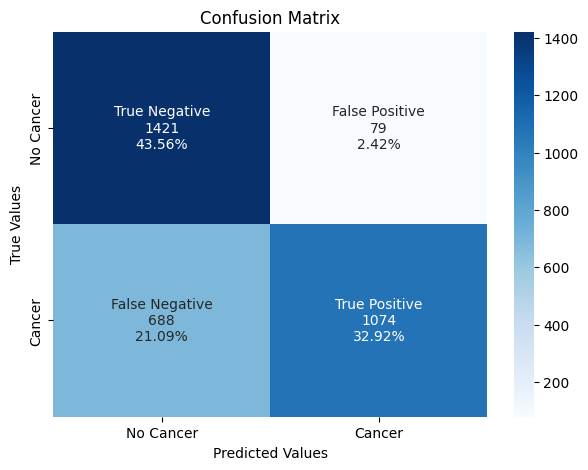

Current Learning Rate: 0.001
Training the model


Epoch 2, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=81.5, loss=0.00478]


Training metrics for Epoch 2:
Accuracy: 0.8146558332055802
ROC: 0.8201741413567981
Precision: 0.8882550335570469
Recall: 0.7513482827135963
F1 score: 0.8140858065508226
Train loss: 0.0048
Validating the trained model's performance


Validation 2: 100%|██████████| 102/102 [00:06<00:00, 15.02batch/s, accuracy=77.3, loss=0.018]


Validation metrics for Epoch 2:
Accuracy: 0.772838749233599
ROC: 0.7719337873628452
Precision: 0.7935595169637722
Recall: 0.7832009080590239
F1 score: 0.7883461868037703
Validation Loss: 0.0180
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.79      0.78      0.79      1762
   No Cancer       0.75      0.76      0.75      1500

    accuracy                           0.77      3262
   macro avg       0.77      0.77      0.77      3262
weighted avg       0.77      0.77      0.77      3262



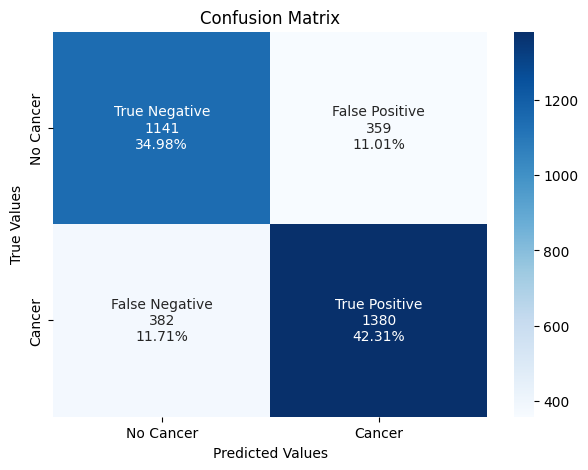

Current Learning Rate: 0.001
Training the model


Epoch 3, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=85.2, loss=0.00404]


Training metrics for Epoch 3:
Accuracy: 0.8520619346926261
ROC: 0.8553727883432682
Precision: 0.9024543738200126
Recall: 0.8140789100198694
F1 score: 0.8559916430383525
Train loss: 0.0040
Validating the trained model's performance


Validation 3: 100%|██████████| 102/102 [00:06<00:00, 14.83batch/s, accuracy=72.3, loss=0.0346]


Validation metrics for Epoch 3:
Accuracy: 0.723175965665236
ROC: 0.7075251608021187
Precision: 0.6850495476087893
Recall: 0.9023836549375709
F1 score: 0.7788390889052168
Validation Loss: 0.0346
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.69      0.90      0.78      1762
   No Cancer       0.82      0.51      0.63      1500

    accuracy                           0.72      3262
   macro avg       0.75      0.71      0.70      3262
weighted avg       0.75      0.72      0.71      3262



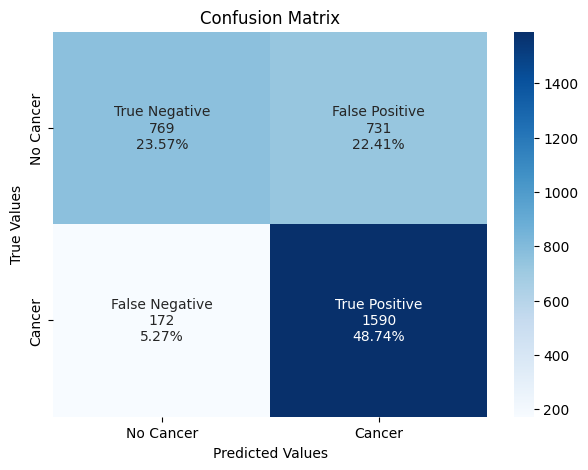

Current Learning Rate: 0.001
Training the model


Epoch 4, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=89, loss=0.00324]  


Training metrics for Epoch 4:
Accuracy: 0.890081250958148
ROC: 0.8919308827703663
Precision: 0.9231001206272618
Recall: 0.8688617655407324
F1 score: 0.8951601111273577
Train loss: 0.0032
Validating the trained model's performance


Validation 4: 100%|██████████| 102/102 [00:06<00:00, 15.00batch/s, accuracy=67.5, loss=0.0655]


Validation metrics for Epoch 4:
Accuracy: 0.6753525444512569
ROC: 0.6547321225879682
Precision: 0.6400956556396971
Recall: 0.9114642451759364
F1 score: 0.7520487005385156
Validation Loss: 0.0655
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.64      0.91      0.75      1762
   No Cancer       0.79      0.40      0.53      1500

    accuracy                           0.68      3262
   macro avg       0.72      0.65      0.64      3262
weighted avg       0.71      0.68      0.65      3262



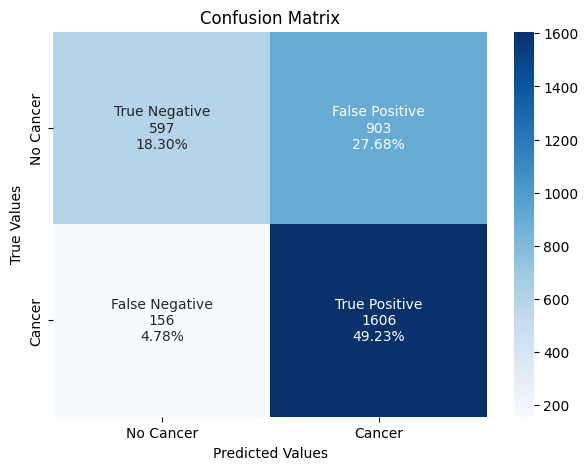

Current Learning Rate: 0.001
Training the model


Epoch 5, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=91.5, loss=0.00265]


Training metrics for Epoch 5:
Accuracy: 0.9150697531810517
ROC: 0.916227457659192
Precision: 0.9385524372230428
Recall: 0.9017882486517173
F1 score: 0.9198031268094962
Train loss: 0.0026
Validating the trained model's performance


Validation 5: 100%|██████████| 102/102 [00:06<00:00, 14.99batch/s, accuracy=81, loss=0.0179]  


Validation metrics for Epoch 5:
Accuracy: 0.8102391171060699
ROC: 0.8127491486946651
Precision: 0.8547486033519553
Recall: 0.7814982973893303
F1 score: 0.8164838422769048
Validation Loss: 0.0179
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.85      0.78      0.82      1762
   No Cancer       0.77      0.84      0.80      1500

    accuracy                           0.81      3262
   macro avg       0.81      0.81      0.81      3262
weighted avg       0.81      0.81      0.81      3262



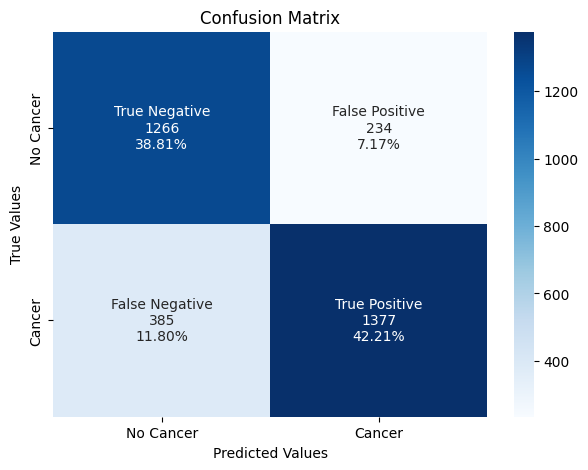

Current Learning Rate: 0.001
Training the model


Epoch 6, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=94.3, loss=0.00188]


Training metrics for Epoch 6:
Accuracy: 0.9425111145178598
ROC: 0.943215441385183
Precision: 0.9580908032596042
Recall: 0.9344308827703661
F1 score: 0.9461129472625377
Train loss: 0.0019
Validating the trained model's performance


Validation 6: 100%|██████████| 102/102 [00:06<00:00, 14.82batch/s, accuracy=74, loss=0.0285] 


Validation metrics for Epoch 6:
Accuracy: 0.740343347639485
ROC: 0.7257953083617101
Precision: 0.7005699254712845
Recall: 0.9069239500567536
F1 score: 0.7905021023992085
Validation Loss: 0.0285
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.70      0.91      0.79      1762
   No Cancer       0.83      0.54      0.66      1500

    accuracy                           0.74      3262
   macro avg       0.77      0.73      0.72      3262
weighted avg       0.76      0.74      0.73      3262



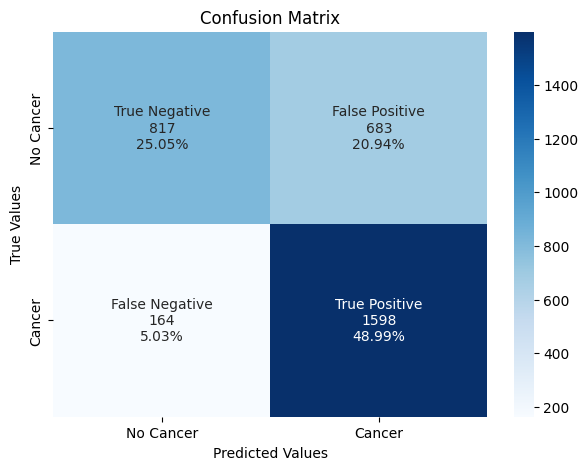

Current Learning Rate: 0.001
Training the model


Epoch 7, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=95.7, loss=0.00148]


Training metrics for Epoch 7:
Accuracy: 0.9569216618120496
ROC: 0.957471804333428
Precision: 0.9690393518518519
Recall: 0.9506102753335226
F1 score: 0.9597363519128815
Train loss: 0.0015
Validating the trained model's performance


Validation 7: 100%|██████████| 102/102 [00:06<00:00, 14.99batch/s, accuracy=83, loss=0.0187]  


Validation metrics for Epoch 7:
Accuracy: 0.8304721030042919
ROC: 0.8258274687854711
Precision: 0.8173228346456692
Recall: 0.8836549375709422
F1 score: 0.8491955276793018
Validation Loss: 0.0187
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.82      0.88      0.85      1762
   No Cancer       0.85      0.77      0.81      1500

    accuracy                           0.83      3262
   macro avg       0.83      0.83      0.83      3262
weighted avg       0.83      0.83      0.83      3262



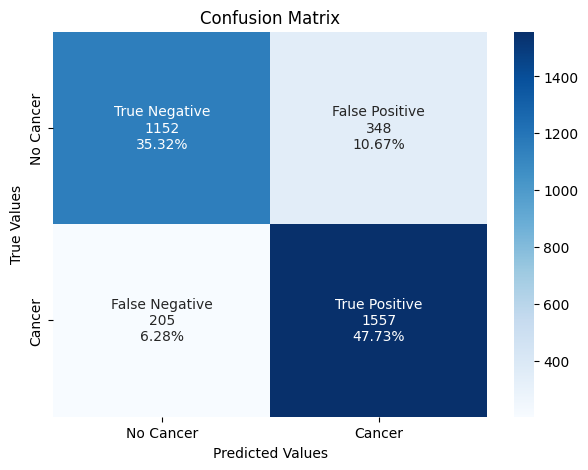

Current Learning Rate: 0.001
Training the model


Epoch 8, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=97.1, loss=0.00106] 


Training metrics for Epoch 8:
Accuracy: 0.9708722980223823
ROC: 0.9711291985996783
Precision: 0.9779179810725552
Recall: 0.9679250638660233
F1 score: 0.9728958630527818
Train loss: 0.0011
Validating the trained model's performance


Validation 8: 100%|██████████| 102/102 [00:06<00:00, 14.91batch/s, accuracy=79.2, loss=0.0294]


Validation metrics for Epoch 8:
Accuracy: 0.7918454935622318
ROC: 0.7859091940976163
Precision: 0.7781201848998459
Recall: 0.8598183881952327
F1 score: 0.8169317875438123
Validation Loss: 0.0294
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.78      0.86      0.82      1762
   No Cancer       0.81      0.71      0.76      1500

    accuracy                           0.79      3262
   macro avg       0.80      0.79      0.79      3262
weighted avg       0.79      0.79      0.79      3262



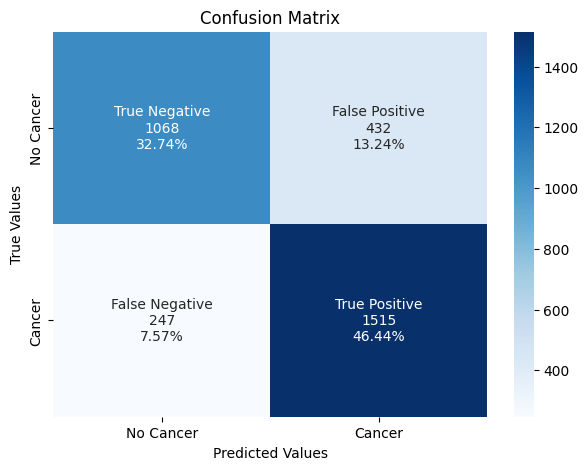

Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Current Learning Rate: 0.0001
Training the model


Epoch 9, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=98.3, loss=0.000618]


Training metrics for Epoch 9:
Accuracy: 0.9834432009811437
ROC: 0.9836082410824109
Precision: 0.9877177949157384
Recall: 0.981549815498155
F1 score: 0.984624145785877
Train loss: 0.0006
Validating the trained model's performance


Validation 9: 100%|██████████| 102/102 [00:06<00:00, 14.85batch/s, accuracy=86.9, loss=0.0145]


Validation metrics for Epoch 9:
Accuracy: 0.8694052728387492
ROC: 0.8710355656451002
Precision: 0.9019253910950662
Recall: 0.8507377979568672
F1 score: 0.8755841121495328
Validation Loss: 0.0145
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.90      0.85      0.88      1762
   No Cancer       0.84      0.89      0.86      1500

    accuracy                           0.87      3262
   macro avg       0.87      0.87      0.87      3262
weighted avg       0.87      0.87      0.87      3262



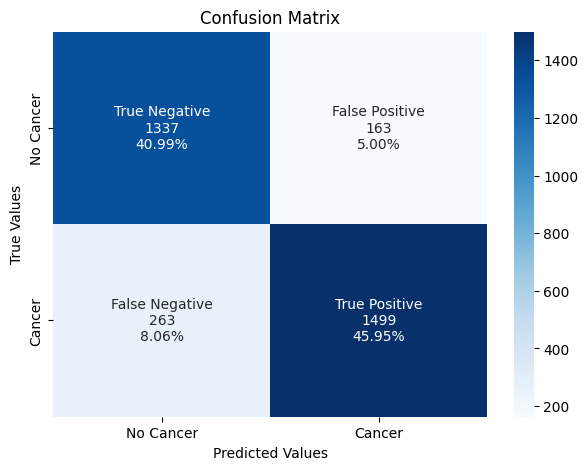

Current Learning Rate: 0.0001
Training the model


Epoch 10, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=99.5, loss=0.000236]


Training metrics for Epoch 10:
Accuracy: 0.9954008891614288
ROC: 0.9954948434099726
Precision: 0.9971534301167093
Recall: 0.9943230201532784
F1 score: 0.9957362137578168
Train loss: 0.0002
Validating the trained model's performance


Validation 10: 100%|██████████| 102/102 [00:06<00:00, 14.98batch/s, accuracy=87.3, loss=0.0157]


Validation metrics for Epoch 10:
Accuracy: 0.8733905579399142
ROC: 0.877450624290579
Precision: 0.9309904153354632
Recall: 0.8269012485811578
F1 score: 0.8758641418695521
Validation Loss: 0.0157
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.93      0.83      0.88      1762
   No Cancer       0.82      0.93      0.87      1500

    accuracy                           0.87      3262
   macro avg       0.88      0.88      0.87      3262
weighted avg       0.88      0.87      0.87      3262



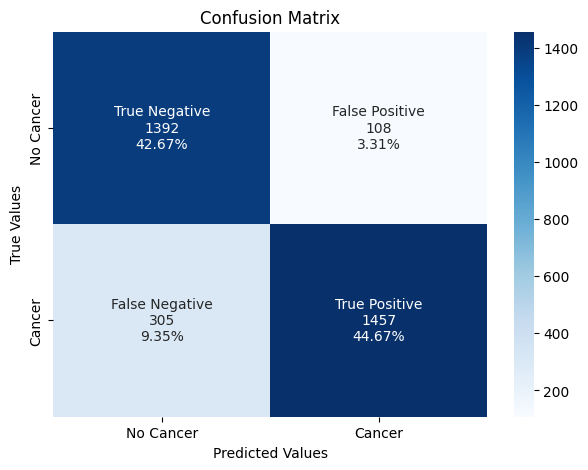

Current Learning Rate: 0.0001
Training the model


Epoch 11, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=99.8, loss=0.000123]


Training metrics for Epoch 11:
Accuracy: 0.9981603556645715
ROC: 0.998197937363989
Precision: 0.9988633134413185
Recall: 0.9977292080613114
F1 score: 0.9982959386537915
Train loss: 0.0001
Validating the trained model's performance


Validation 11: 100%|██████████| 102/102 [00:06<00:00, 14.72batch/s, accuracy=87.4, loss=0.0163]


Validation metrics for Epoch 11:
Accuracy: 0.8740036787247087
ROC: 0.8769277336360196
Precision: 0.9193047796399751
Recall: 0.840522133938706
F1 score: 0.8781500148235991
Validation Loss: 0.0163
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.92      0.84      0.88      1762
   No Cancer       0.83      0.91      0.87      1500

    accuracy                           0.87      3262
   macro avg       0.87      0.88      0.87      3262
weighted avg       0.88      0.87      0.87      3262



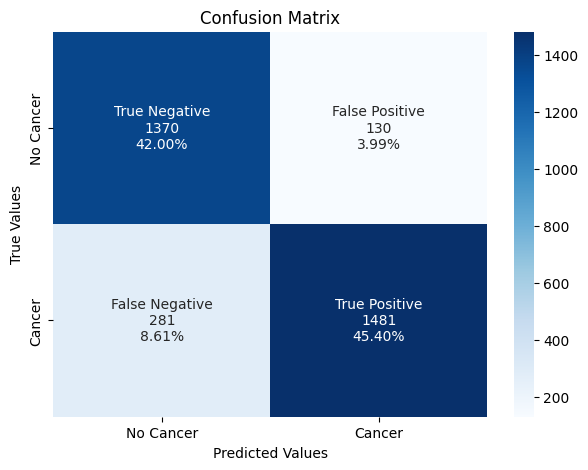

Current Learning Rate: 0.0001
Training the model


Epoch 12, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=99.8, loss=9.16e-5] 


Training metrics for Epoch 12:
Accuracy: 0.9981603556645715
ROC: 0.9981237108524932
Precision: 0.9980141843971632
Recall: 0.9985807550383197
F1 score: 0.9982973893303065
Train loss: 0.0001
Validating the trained model's performance


Validation 12: 100%|██████████| 102/102 [00:06<00:00, 14.93batch/s, accuracy=87.6, loss=0.017] 


Validation metrics for Epoch 12:
Accuracy: 0.8761496014714899
ROC: 0.8790628074158153
Precision: 0.9212158808933002
Recall: 0.8427922814982974
F1 score: 0.8802608180201542
Validation Loss: 0.0170
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.92      0.84      0.88      1762
   No Cancer       0.83      0.92      0.87      1500

    accuracy                           0.88      3262
   macro avg       0.88      0.88      0.88      3262
weighted avg       0.88      0.88      0.88      3262



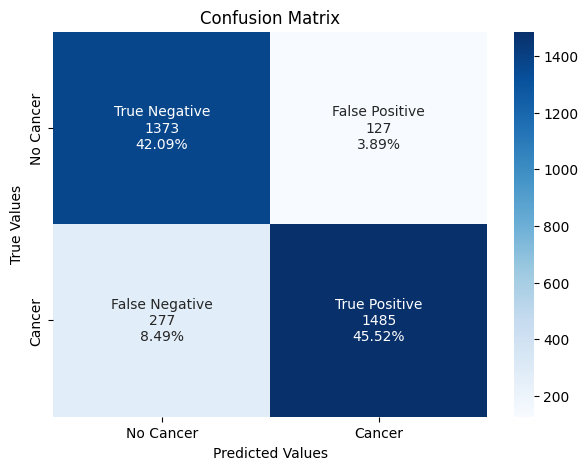

Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.
Current Learning Rate: 1e-05
Training the model


Epoch 13, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=99.9, loss=7.67e-5] 


Training metrics for Epoch 13:
Accuracy: 0.9986202667484286
ROC: 0.998697937363989
Precision: 0.9997155858930603
Recall: 0.9977292080613114
F1 score: 0.9987214092910924
Train loss: 0.0001
Validating the trained model's performance


Validation 13: 100%|██████████| 102/102 [00:06<00:00, 14.88batch/s, accuracy=87.5, loss=0.0171]


Validation metrics for Epoch 13:
Accuracy: 0.875229920294298
ROC: 0.8778149829738934
Precision: 0.916923076923077
Recall: 0.8456299659477866
F1 score: 0.8798346619427221
Validation Loss: 0.0171
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.92      0.85      0.88      1762
   No Cancer       0.83      0.91      0.87      1500

    accuracy                           0.88      3262
   macro avg       0.88      0.88      0.88      3262
weighted avg       0.88      0.88      0.88      3262



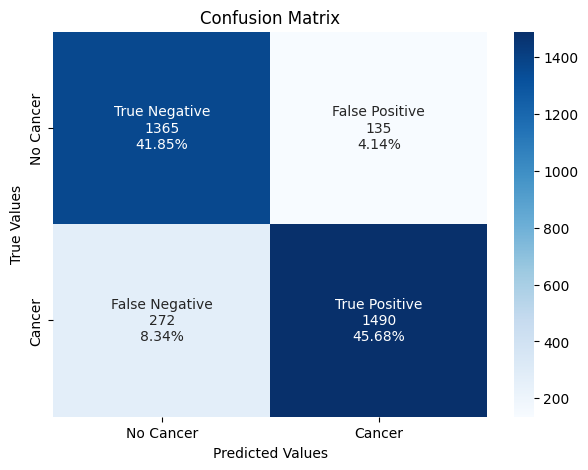

Current Learning Rate: 1e-05
Training the model


Epoch 14, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=99.9, loss=7.93e-5] 


Training metrics for Epoch 14:
Accuracy: 0.9986202667484286
ROC: 0.9986731951934904
Precision: 0.9994314951677089
Recall: 0.9980130570536475
F1 score: 0.9987217724755008
Train loss: 0.0001
Validating the trained model's performance


Validation 14: 100%|██████████| 102/102 [00:06<00:00, 14.94batch/s, accuracy=87.5, loss=0.0172]


Validation metrics for Epoch 14:
Accuracy: 0.8746167995095033
ROC: 0.876950056753689
Precision: 0.9137614678899083
Recall: 0.8479001135073779
F1 score: 0.8795996467471298
Validation Loss: 0.0172
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.91      0.85      0.88      1762
   No Cancer       0.84      0.91      0.87      1500

    accuracy                           0.87      3262
   macro avg       0.87      0.88      0.87      3262
weighted avg       0.88      0.87      0.87      3262



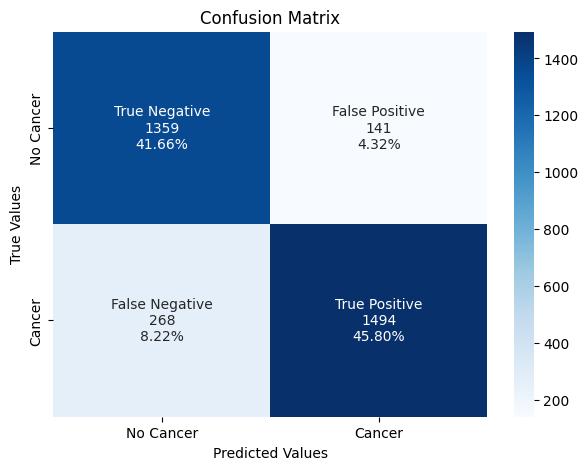

Current Learning Rate: 1e-05
Training the model


Epoch 15, Training: 100%|██████████| 82/82 [00:43<00:00,  1.91batch/s, accuracy=99.9, loss=6.52e-5]


Training metrics for Epoch 15:
Accuracy: 0.9989268741376667
ROC: 0.9989075598448293
Precision: 0.9988649262202043
Recall: 0.9991484530229918
F1 score: 0.9990066695047538
Train loss: 0.0001
Validating the trained model's performance


Validation 15: 100%|██████████| 102/102 [00:06<00:00, 14.84batch/s, accuracy=87.5, loss=0.0173]


Validation metrics for Epoch 15:
Accuracy: 0.8746167995095033
ROC: 0.8768013620885358
Precision: 0.9122486288848263
Recall: 0.8496027241770715
F1 score: 0.879811930649427
Validation Loss: 0.0173
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.91      0.85      0.88      1762
   No Cancer       0.84      0.90      0.87      1500

    accuracy                           0.87      3262
   macro avg       0.87      0.88      0.87      3262
weighted avg       0.88      0.87      0.87      3262



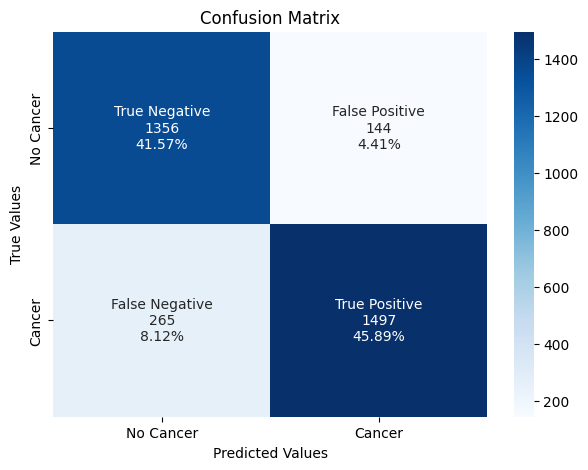

Epoch 00015: reducing learning rate of group 0 to 1.0000e-06.
Current Learning Rate: 1.0000000000000002e-06
Early stopping inside the current fold!
Finished Training


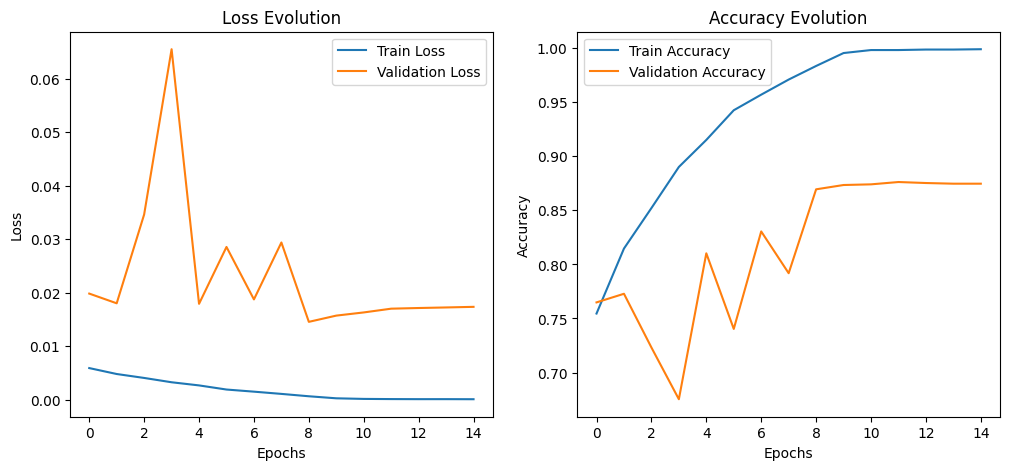

Finished Training for Fold 1
The best model performance in fold 1 - Val Acc: 0.8746 Precision: 0.9122 Recall: 0.8496 F1: 0.8803 ROC: 0.8768
---------- Fold: 2 ----------
Dimensions of train_data: (6523, 10)
Dimensions of valid_data: (3262, 10)
Class Cancer: Training instances - 3523, Validation instances - 1762
Class No Cancer: Training instances - 3000, Validation instances - 1500
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=93.1, loss=0.00392]


Training metrics for Epoch 1:
Accuracy: 0.9305534263375748
ROC: 0.9308339956476488
Precision: 0.9431293302540416
Recall: 0.9273346579619642
F1 score: 0.9351653069987118
Train loss: 0.0039
Validating the trained model's performance


Validation 1: 100%|██████████| 102/102 [00:06<00:00, 14.89batch/s, accuracy=100, loss=8.21e-5] 


Validation metrics for Epoch 1:
Accuracy: 0.9996934396076027
ROC: 0.9997162315550511
Precision: 1.0
Recall: 0.9994324631101021
F1 score: 0.9997161510076639
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00      1762
   No Cancer       1.00      1.00      1.00      1500

    accuracy                           1.00      3262
   macro avg       1.00      1.00      1.00      3262
weighted avg       1.00      1.00      1.00      3262



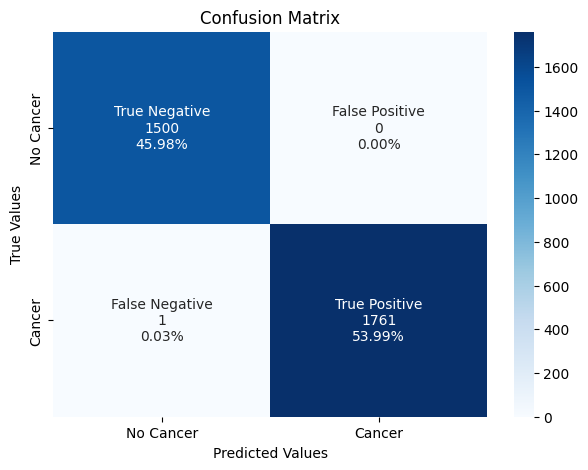

Current Learning Rate: 1.0000000000000002e-06
Training the model


Epoch 2, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=93, loss=0.00377]  


Training metrics for Epoch 2:
Accuracy: 0.9296336041698605
ROC: 0.9303040968871227
Precision: 0.9463869463869464
Recall: 0.9219415271075788
F1 score: 0.9340043134435658
Train loss: 0.0038
Validating the trained model's performance


Validation 2: 100%|██████████| 102/102 [00:06<00:00, 14.89batch/s, accuracy=100, loss=8.13e-5] 


Validation metrics for Epoch 2:
Accuracy: 0.9996934396076027
ROC: 0.9997162315550511
Precision: 1.0
Recall: 0.9994324631101021
F1 score: 0.9997161510076639
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00      1762
   No Cancer       1.00      1.00      1.00      1500

    accuracy                           1.00      3262
   macro avg       1.00      1.00      1.00      3262
weighted avg       1.00      1.00      1.00      3262



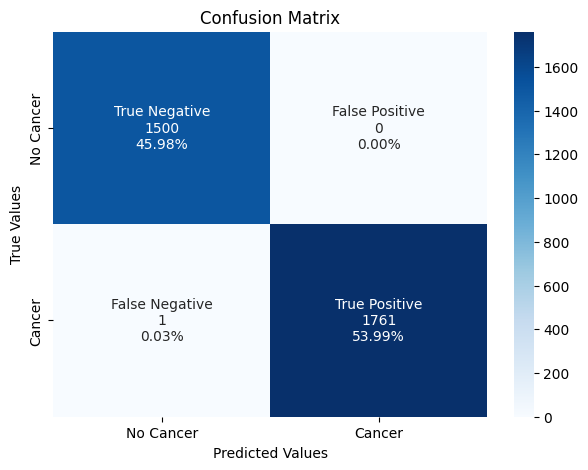

Current Learning Rate: 1.0000000000000002e-06
Training the model


Epoch 3, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=93.1, loss=0.00367]


Training metrics for Epoch 3:
Accuracy: 0.931473248505289
ROC: 0.9321061595231337
Precision: 0.9476135040745053
Recall: 0.9242123190462674
F1 score: 0.9357666331369451
Train loss: 0.0037
Validating the trained model's performance


Validation 3: 100%|██████████| 102/102 [00:06<00:00, 14.93batch/s, accuracy=100, loss=8.05e-5] 


Validation metrics for Epoch 3:
Accuracy: 0.9996934396076027
ROC: 0.9997162315550511
Precision: 1.0
Recall: 0.9994324631101021
F1 score: 0.9997161510076639
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00      1762
   No Cancer       1.00      1.00      1.00      1500

    accuracy                           1.00      3262
   macro avg       1.00      1.00      1.00      3262
weighted avg       1.00      1.00      1.00      3262



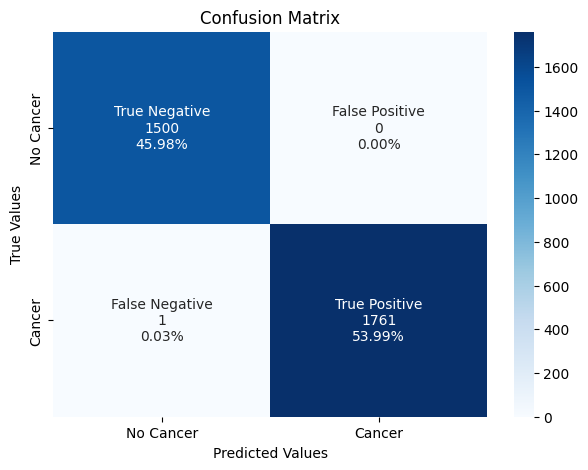

Current Learning Rate: 1.0000000000000002e-06
Training the model


Epoch 4, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=93.3, loss=0.00361]


Training metrics for Epoch 4:
Accuracy: 0.9333128928407175
ROC: 0.9339577065001419
Precision: 0.9493597206053551
Recall: 0.9259154130002839
F1 score: 0.9374910188245438
Train loss: 0.0036
Validating the trained model's performance


Validation 4: 100%|██████████| 102/102 [00:06<00:00, 14.79batch/s, accuracy=100, loss=8.15e-5] 


Validation metrics for Epoch 4:
Accuracy: 0.9996934396076027
ROC: 0.9997162315550511
Precision: 1.0
Recall: 0.9994324631101021
F1 score: 0.9997161510076639
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00      1762
   No Cancer       1.00      1.00      1.00      1500

    accuracy                           1.00      3262
   macro avg       1.00      1.00      1.00      3262
weighted avg       1.00      1.00      1.00      3262



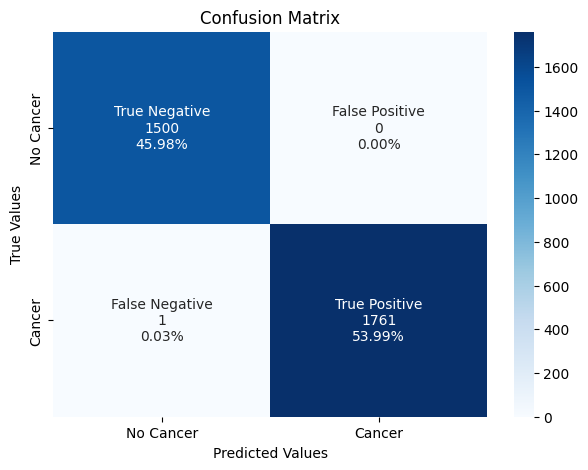

Current Learning Rate: 1.0000000000000002e-06
Early stopping inside the current fold!
Finished Training


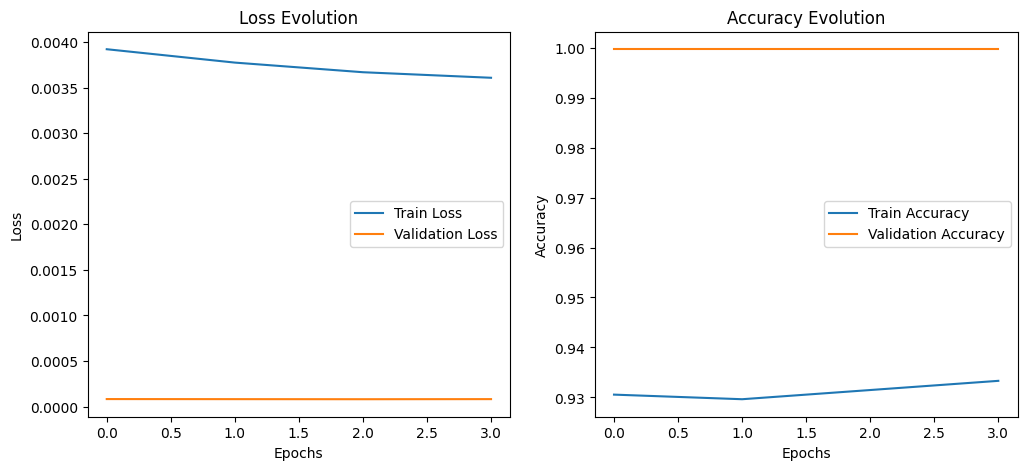

Finished Training for Fold 2
The best model performance in fold 2 - Val Acc: 0.9997 Precision: 1.0000 Recall: 0.9994 F1: 0.9997 ROC: 0.9997
---------- Fold: 3 ----------
Dimensions of train_data: (6524, 10)
Dimensions of valid_data: (3261, 10)
Class Cancer: Training instances - 3524, Validation instances - 1761
Class No Cancer: Training instances - 3000, Validation instances - 1500
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 82/82 [00:43<00:00,  1.90batch/s, accuracy=93.2, loss=0.00346]


Training metrics for Epoch 1:
Accuracy: 0.9324034334763949
ROC: 0.9327451759364359
Precision: 0.9453915053452759
Recall: 0.9284903518728718
F1 score: 0.9368647100930565
Train loss: 0.0035
Validating the trained model's performance


Validation 1: 100%|██████████| 102/102 [00:06<00:00, 14.83batch/s, accuracy=99.9, loss=0.000105]


Validation metrics for Epoch 1:
Accuracy: 0.9993866911990187
ROC: 0.9994321408290744
Precision: 1.0
Recall: 0.9988642816581488
F1 score: 0.9994318181818181
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00      1761
   No Cancer       1.00      1.00      1.00      1500

    accuracy                           1.00      3261
   macro avg       1.00      1.00      1.00      3261
weighted avg       1.00      1.00      1.00      3261



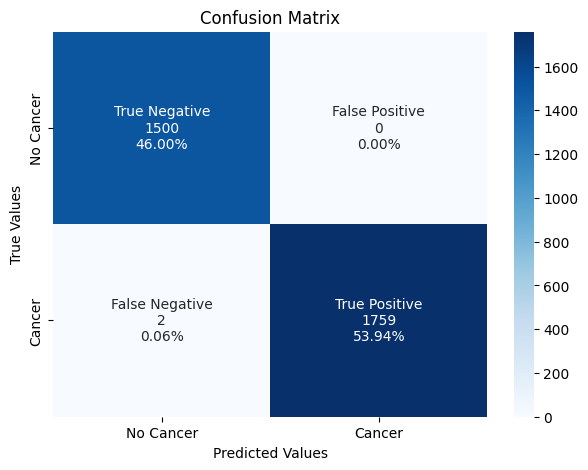

Current Learning Rate: 1.0000000000000002e-06
Training the model


Epoch 2, Training: 100%|██████████| 82/82 [00:43<00:00,  1.90batch/s, accuracy=93.5, loss=0.00332]


Training metrics for Epoch 2:
Accuracy: 0.9345493562231759
ROC: 0.9348306848278471
Precision: 0.9466397461782521
Recall: 0.9313280363223609
F1 score: 0.9389214704620226
Train loss: 0.0033
Validating the trained model's performance


Validation 2: 100%|██████████| 102/102 [00:06<00:00, 14.94batch/s, accuracy=99.9, loss=0.000106]


Validation metrics for Epoch 2:
Accuracy: 0.9993866911990187
ROC: 0.9994321408290744
Precision: 1.0
Recall: 0.9988642816581488
F1 score: 0.9994318181818181
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00      1761
   No Cancer       1.00      1.00      1.00      1500

    accuracy                           1.00      3261
   macro avg       1.00      1.00      1.00      3261
weighted avg       1.00      1.00      1.00      3261



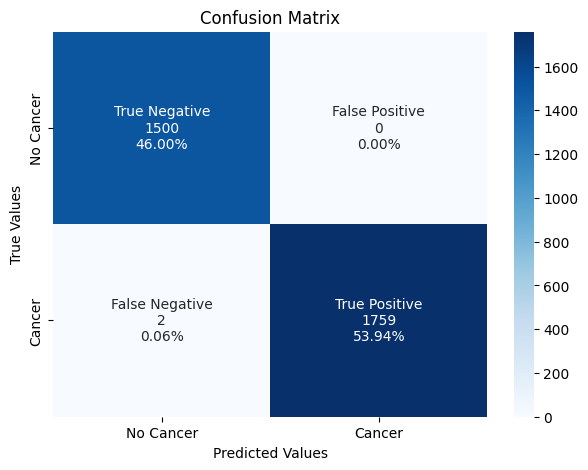

Epoch 00021: reducing learning rate of group 0 to 1.0000e-07.
Current Learning Rate: 1.0000000000000002e-07
Training the model


Epoch 3, Training: 100%|██████████| 82/82 [00:43<00:00,  1.91batch/s, accuracy=93.3, loss=0.00334]


Training metrics for Epoch 3:
Accuracy: 0.9333231146535867
ROC: 0.9338690881573969
Precision: 0.9483309143686502
Recall: 0.9270715096481271
F1 score: 0.9375807145931985
Train loss: 0.0033
Validating the trained model's performance


Validation 3: 100%|██████████| 102/102 [00:06<00:00, 14.91batch/s, accuracy=99.9, loss=0.000105]


Validation metrics for Epoch 3:
Accuracy: 0.9993866911990187
ROC: 0.9994321408290744
Precision: 1.0
Recall: 0.9988642816581488
F1 score: 0.9994318181818181
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00      1761
   No Cancer       1.00      1.00      1.00      1500

    accuracy                           1.00      3261
   macro avg       1.00      1.00      1.00      3261
weighted avg       1.00      1.00      1.00      3261



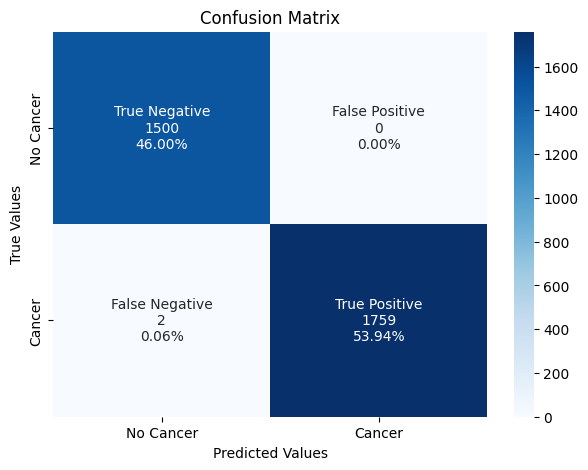

Current Learning Rate: 1.0000000000000002e-07
Training the model


Epoch 4, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=93.3, loss=0.00335]


Training metrics for Epoch 4:
Accuracy: 0.9330165542611895
ROC: 0.933461407491487
Precision: 0.947002606429192
Recall: 0.9279228149829739
F1 score: 0.9373656299269028
Train loss: 0.0034
Validating the trained model's performance


Validation 4: 100%|██████████| 102/102 [00:06<00:00, 15.02batch/s, accuracy=99.9, loss=0.000105]


Validation metrics for Epoch 4:
Accuracy: 0.9993866911990187
ROC: 0.9994321408290744
Precision: 1.0
Recall: 0.9988642816581488
F1 score: 0.9994318181818181
Validation Loss: 0.0001
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00      1761
   No Cancer       1.00      1.00      1.00      1500

    accuracy                           1.00      3261
   macro avg       1.00      1.00      1.00      3261
weighted avg       1.00      1.00      1.00      3261



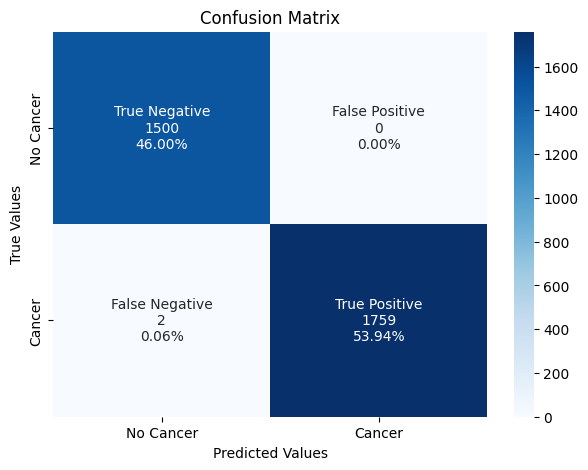

Current Learning Rate: 1.0000000000000002e-07
Early stopping inside the current fold!
Finished Training


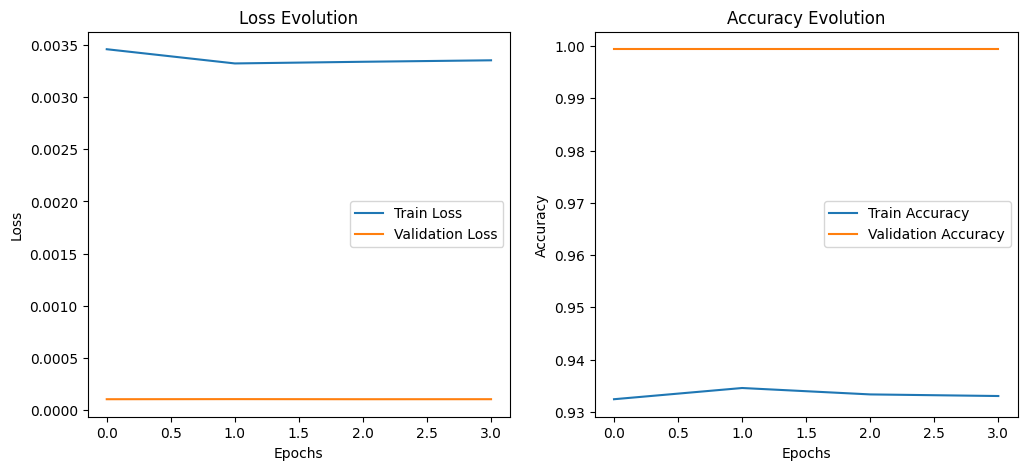

Finished Training for Fold 3
The best model performance in fold 3 - Val Acc: 0.9994 Precision: 1.0000 Recall: 0.9989 F1: 0.9994 ROC: 0.9994
The overall best model has been saved with metrics - Val Acc: 0.9997, Precision: 1.0000, Recall: 0.9994, F1: 0.9997, ROC: 0.9997
Log file at /kaggle/working/Logs/logs_1.0.0.txt has been closed.


In [46]:
# Configuration des hyperparamètres
hyperparameters = {
    "folds": 3,  # Nombre de folds pour la validation croisée
    "num_workers": 2,  # Nombre de workers pour le DataLoader
    "val_batch_size": 32,  # Taille du batch pour la validation
    "train_batch_size": 80,  # Taille du batch pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage
    "num_epochs": 20,  # Nombre d'époques pour l'entraînement
    "early_stopping_patience": 3,  # Patience pour l'arrêt anticipé
    'save_best_model_dir': save_best_model_dir
}

# Initialisation du modèle
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié

version = '1.0.0'

train_model_cross_validation(model,processed_df,hyperparameters)

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

class OptimizedEffNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = EfficientNet.from_pretrained('efficientnet-b2')
        
        # (CSV)
        self.csv = nn.Sequential(
            nn.Linear(self.no_columns, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        
        # Define Classification part
        self.classification = nn.Sequential(
            nn.Linear(1408 + 256, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(1024, self.output_size)
        )
        
    def forward(self, image, meta, prints=False):
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features.extract_features(image)
        image = F.adaptive_avg_pool2d(image, 1).reshape(-1, 1408)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data shape:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data shape:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Output shape:', out.shape)
        
        return out

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (6523, 10)
Dimensions of valid_data: (3262, 10)
Class Cancer: Training instances - 3523, Validation instances - 1762
Class No Cancer: Training instances - 3000, Validation instances - 1500
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=74.2, loss=0.00603]


Training metrics for Epoch 1:
Accuracy: 0.7419898819561551
ROC: 0.7485225659948906
Precision: 0.8216783216783217
Recall: 0.6670451319897814
F1 score: 0.7363308788970703
Train loss: 0.0060
Validating the trained model's performance


Validation 1: 100%|██████████| 102/102 [00:06<00:00, 14.85batch/s, accuracy=73.6, loss=0.0181]


Validation metrics for Epoch 1:
Accuracy: 0.7357449417535254
ROC: 0.7501872871736662
Precision: 0.9054054054054054
Recall: 0.5703745743473326
F1 score: 0.6998607242339833
Validation Loss: 0.0181
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.91      0.57      0.70      1762
   No Cancer       0.65      0.93      0.76      1500

    accuracy                           0.74      3262
   macro avg       0.78      0.75      0.73      3262
weighted avg       0.79      0.74      0.73      3262



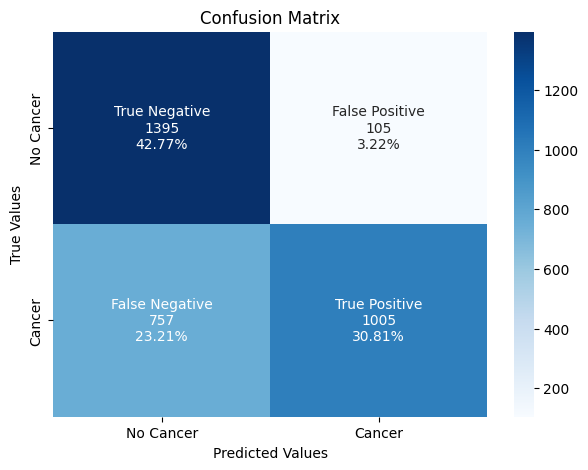

Current Learning Rate: 0.001
Training the model


Epoch 2, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=80.6, loss=0.00498]


Training metrics for Epoch 2:
Accuracy: 0.8057642189176759
ROC: 0.8117198410445643
Precision: 0.8836734693877552
Recall: 0.7374396820891286
F1 score: 0.8039610088194337
Train loss: 0.0050
Validating the trained model's performance


Validation 2: 100%|██████████| 102/102 [00:06<00:00, 14.98batch/s, accuracy=80, loss=0.0171] 


Validation metrics for Epoch 2:
Accuracy: 0.7998160637645616
ROC: 0.8061740446462353
Precision: 0.8816242257398486
Recall: 0.7270147559591373
F1 score: 0.7968895800933126
Validation Loss: 0.0171
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.88      0.73      0.80      1762
   No Cancer       0.73      0.89      0.80      1500

    accuracy                           0.80      3262
   macro avg       0.81      0.81      0.80      3262
weighted avg       0.81      0.80      0.80      3262



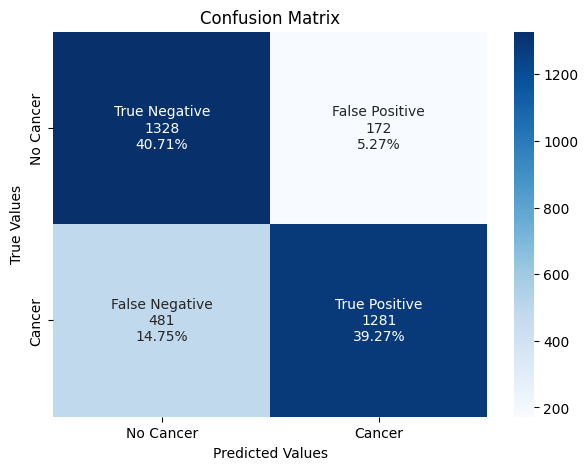

Current Learning Rate: 0.001
Training the model


Epoch 3, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=84.3, loss=0.0043] 


Training metrics for Epoch 3:
Accuracy: 0.8434769277939599
ROC: 0.8472023370233702
Precision: 0.8984076433121019
Recall: 0.8007380073800738
F1 score: 0.8467657211466305
Train loss: 0.0043
Validating the trained model's performance


Validation 3: 100%|██████████| 102/102 [00:06<00:00, 14.95batch/s, accuracy=67.6, loss=0.0508]


Validation metrics for Epoch 3:
Accuracy: 0.6759656652360515
ROC: 0.657579644343549
Precision: 0.645721372467962
Recall: 0.8864926220204313
F1 score: 0.7471896675436498
Validation Loss: 0.0508
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.65      0.89      0.75      1762
   No Cancer       0.76      0.43      0.55      1500

    accuracy                           0.68      3262
   macro avg       0.70      0.66      0.65      3262
weighted avg       0.70      0.68      0.66      3262



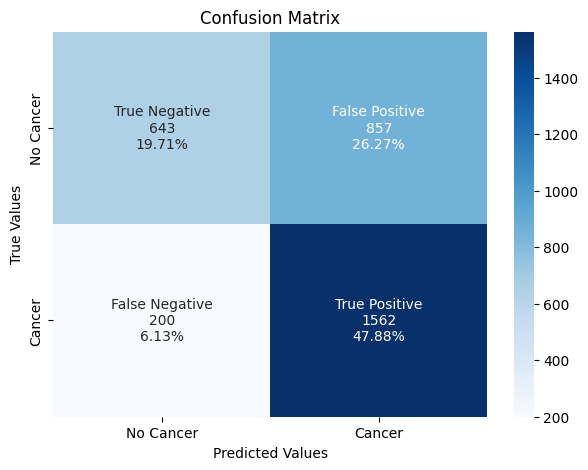

Current Learning Rate: 0.001
Training the model


Epoch 4, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=86.7, loss=0.00355]


Training metrics for Epoch 4:
Accuracy: 0.866932393070673
ROC: 0.8696590500520388
Precision: 0.9106093411691927
Recall: 0.8356514334374113
F1 score: 0.871521610420367
Train loss: 0.0036
Validating the trained model's performance


Validation 4: 100%|██████████| 102/102 [00:06<00:00, 14.94batch/s, accuracy=80.5, loss=0.0204]


Validation metrics for Epoch 4:
Accuracy: 0.8050275904353158
ROC: 0.812683314415437
Precision: 0.9015691868758916
Recall: 0.717366628830874
F1 score: 0.7989886219974716
Validation Loss: 0.0204
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.90      0.72      0.80      1762
   No Cancer       0.73      0.91      0.81      1500

    accuracy                           0.81      3262
   macro avg       0.82      0.81      0.80      3262
weighted avg       0.82      0.81      0.80      3262



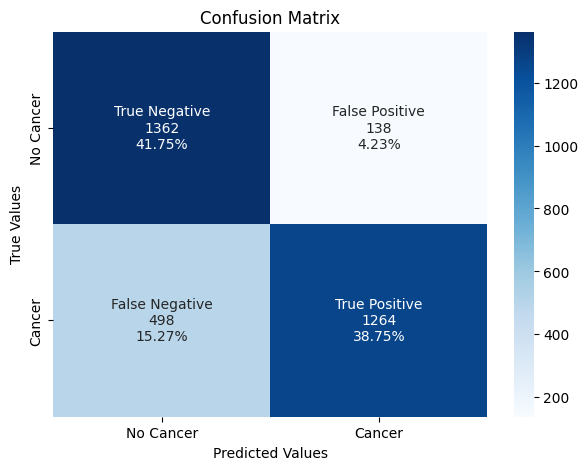

Current Learning Rate: 0.001
Training the model


Epoch 5, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=89, loss=0.00324]  


Training metrics for Epoch 5:
Accuracy: 0.8899279472635291
ROC: 0.8916899895922035
Precision: 0.9220583809810412
Recall: 0.8697133125177405
F1 score: 0.8951212386795209
Train loss: 0.0032
Validating the trained model's performance


Validation 5: 100%|██████████| 102/102 [00:06<00:00, 14.93batch/s, accuracy=81.1, loss=0.0158]


Validation metrics for Epoch 5:
Accuracy: 0.8108522378908645
ROC: 0.8111853953840333
Precision: 0.836962919364332
Recall: 0.8070374574347332
F1 score: 0.8217278243282288
Validation Loss: 0.0158
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.84      0.81      0.82      1762
   No Cancer       0.78      0.82      0.80      1500

    accuracy                           0.81      3262
   macro avg       0.81      0.81      0.81      3262
weighted avg       0.81      0.81      0.81      3262



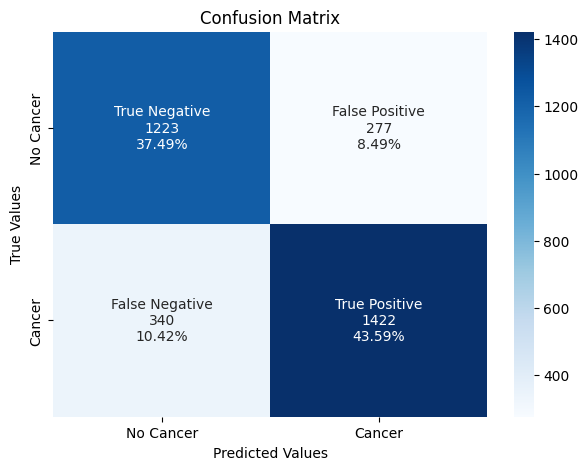

Current Learning Rate: 0.001
Training the model


Epoch 6, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=92.9, loss=0.00227]


Training metrics for Epoch 6:
Accuracy: 0.9293269967806224
ROC: 0.9296985996783045
Precision: 0.9429976851851852
Recall: 0.9250638660232756
F1 score: 0.9339446912165067
Train loss: 0.0023
Validating the trained model's performance


Validation 6: 100%|██████████| 102/102 [00:06<00:00, 14.89batch/s, accuracy=83.1, loss=0.0169]


Validation metrics for Epoch 6:
Accuracy: 0.8307786633966892
ROC: 0.8391963677639046
Precision: 0.9390420899854862
Recall: 0.7343927355278093
F1 score: 0.824203821656051
Validation Loss: 0.0169
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.94      0.73      0.82      1762
   No Cancer       0.75      0.94      0.84      1500

    accuracy                           0.83      3262
   macro avg       0.85      0.84      0.83      3262
weighted avg       0.85      0.83      0.83      3262



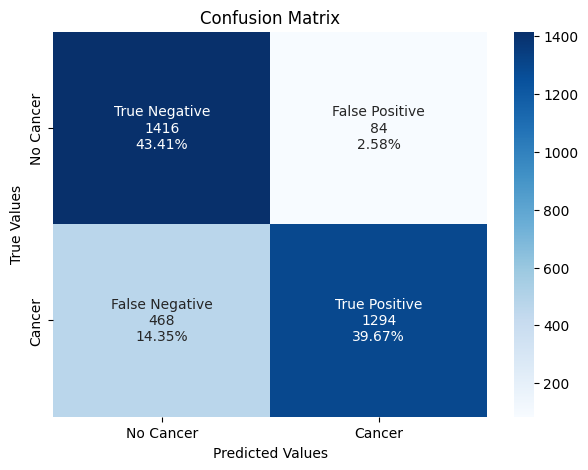

Current Learning Rate: 0.001
Training the model


Epoch 7, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=94.9, loss=0.00163]


Training metrics for Epoch 7:
Accuracy: 0.9494097807757167
ROC: 0.9497010123947394
Precision: 0.9596890296573568
Recall: 0.9460686914561454
F1 score: 0.9528301886792453
Train loss: 0.0016
Validating the trained model's performance


Validation 7: 100%|██████████| 102/102 [00:06<00:00, 14.93batch/s, accuracy=83.3, loss=0.016]


Validation metrics for Epoch 7:
Accuracy: 0.8326180257510729
ROC: 0.8388172531214528
Precision: 0.9141689373297003
Recall: 0.7616345062429057
F1 score: 0.8309597523219814
Validation Loss: 0.0160
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.91      0.76      0.83      1762
   No Cancer       0.77      0.92      0.83      1500

    accuracy                           0.83      3262
   macro avg       0.84      0.84      0.83      3262
weighted avg       0.85      0.83      0.83      3262



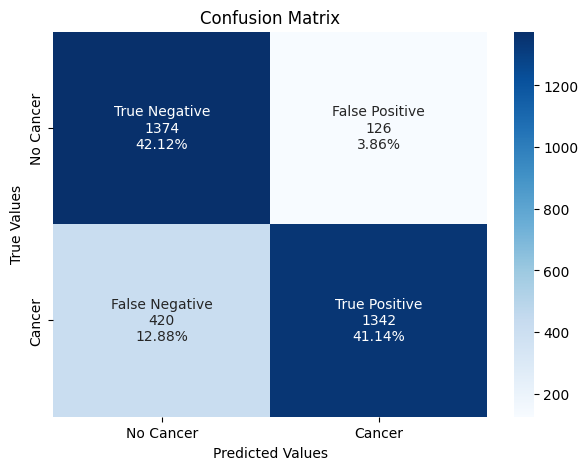

Current Learning Rate: 0.001
Training the model


Epoch 8, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=95.6, loss=0.0015] 


Training metrics for Epoch 8:
Accuracy: 0.9560018396443354
ROC: 0.9561996404579431
Precision: 0.9644087256027555
Recall: 0.9537326142492194
F1 score: 0.959040959040959
Train loss: 0.0015
Validating the trained model's performance


Validation 8: 100%|██████████| 102/102 [00:06<00:00, 14.93batch/s, accuracy=75.2, loss=0.0519]


Validation metrics for Epoch 8:
Accuracy: 0.7522992029429798
ROC: 0.7389440030268635
Precision: 0.7133273703041145
Recall: 0.9052213393870602
F1 score: 0.7978989494747374
Validation Loss: 0.0519
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.71      0.91      0.80      1762
   No Cancer       0.84      0.57      0.68      1500

    accuracy                           0.75      3262
   macro avg       0.78      0.74      0.74      3262
weighted avg       0.77      0.75      0.74      3262



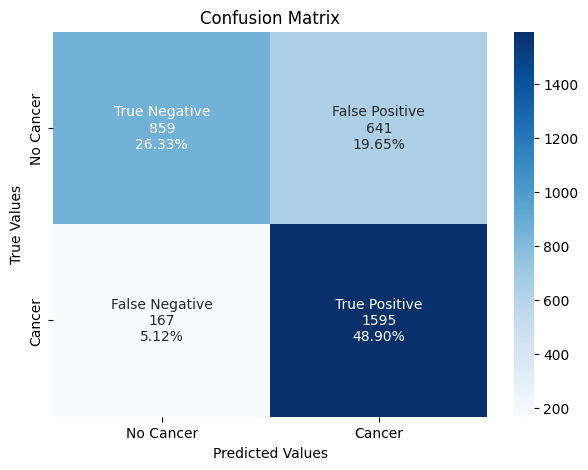

Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Current Learning Rate: 0.0001
Training the model


Epoch 9, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=97.9, loss=0.000797]


Training metrics for Epoch 9:
Accuracy: 0.9791506975318105
ROC: 0.979411675655218
Precision: 0.9851045545688915
Recall: 0.9761566846437695
F1 score: 0.9806102081551183
Train loss: 0.0008
Validating the trained model's performance


Validation 9: 100%|██████████| 102/102 [00:06<00:00, 14.97batch/s, accuracy=73.6, loss=0.0509]


Validation metrics for Epoch 9:
Accuracy: 0.7357449417535254
ROC: 0.7165327279606508
Precision: 0.6823338735818476
Recall: 0.9557321225879682
F1 score: 0.7962174940898346
Validation Loss: 0.0509
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.68      0.96      0.80      1762
   No Cancer       0.90      0.48      0.62      1500

    accuracy                           0.74      3262
   macro avg       0.79      0.72      0.71      3262
weighted avg       0.78      0.74      0.72      3262



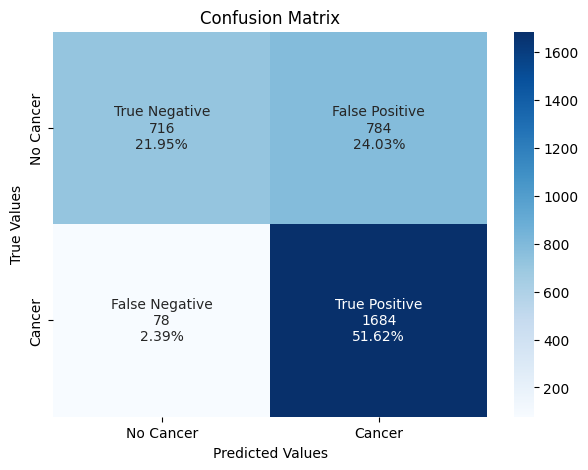

Current Learning Rate: 0.0001
Training the model


Epoch 10, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=99.4, loss=0.000269]


Training metrics for Epoch 10:
Accuracy: 0.9943277632990956
ROC: 0.9943776610843031
Precision: 0.9957337883959044
Recall: 0.9937553221686063
F1 score: 0.9947435715300469
Train loss: 0.0003
Validating the trained model's performance


Validation 10: 100%|██████████| 102/102 [00:06<00:00, 15.02batch/s, accuracy=86.5, loss=0.0175]


Validation metrics for Epoch 10:
Accuracy: 0.8654199877375843
ROC: 0.8654631101021567
Precision: 0.8834782608695653
Recall: 0.8649262202043133
F1 score: 0.8741038141669056
Validation Loss: 0.0175
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.88      0.86      0.87      1762
   No Cancer       0.85      0.87      0.86      1500

    accuracy                           0.87      3262
   macro avg       0.86      0.87      0.86      3262
weighted avg       0.87      0.87      0.87      3262



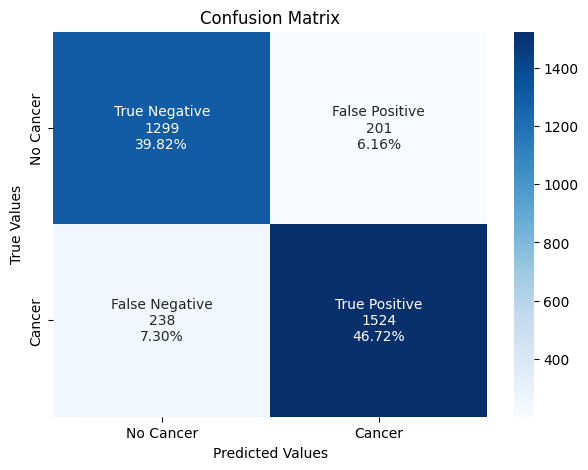

Current Learning Rate: 0.0001
Finished Training


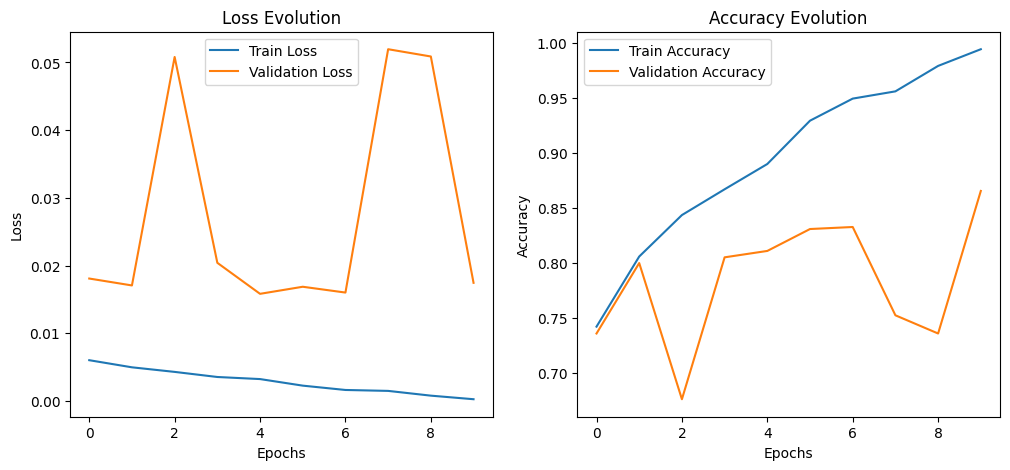

Finished Training for Fold 1
The best model performance in fold 1 - Val Acc: 0.8654 Precision: 0.8835 Recall: 0.8649 F1: 0.8741 ROC: 0.8655
---------- Fold: 2 ----------
Dimensions of train_data: (6523, 10)
Dimensions of valid_data: (3262, 10)
Class Cancer: Training instances - 3523, Validation instances - 1762
Class No Cancer: Training instances - 3000, Validation instances - 1500
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=92.9, loss=0.00282]


Training metrics for Epoch 1:
Accuracy: 0.9285604783075272
ROC: 0.9296570158009272
Precision: 0.9499558433912275
Recall: 0.9159806982685211
F1 score: 0.9326589595375722
Train loss: 0.0028
Validating the trained model's performance


Validation 1: 100%|██████████| 102/102 [00:06<00:00, 14.74batch/s, accuracy=99.1, loss=0.00158]


Validation metrics for Epoch 1:
Accuracy: 0.9914163090128756
ROC: 0.9920544835414302
Precision: 1.0
Recall: 0.9841089670828603
F1 score: 0.9919908466819222
Validation Loss: 0.0016
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.98      0.99      1762
   No Cancer       0.98      1.00      0.99      1500

    accuracy                           0.99      3262
   macro avg       0.99      0.99      0.99      3262
weighted avg       0.99      0.99      0.99      3262



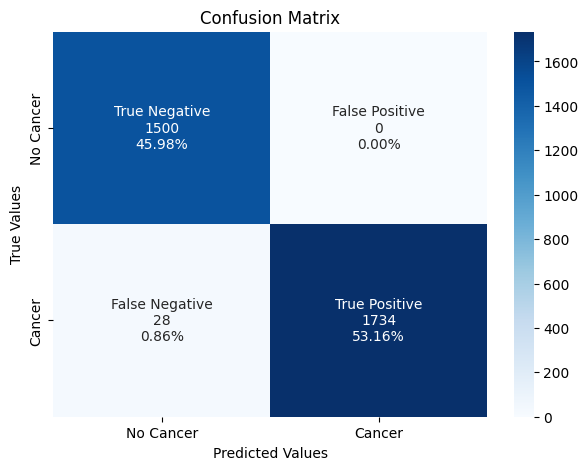

Current Learning Rate: 0.0001
Training the model


Epoch 2, Training:  46%|████▋     | 38/82 [00:20<00:23,  1.84batch/s, accuracy=95.6, loss=0.00172]


KeyboardInterrupt: 

In [48]:
# Configuration des hyperparamètres
hyperparameters = {
    "folds": 3,  # Nombre de folds pour la validation croisée
    "num_workers": 2,  # Nombre de workers pour le DataLoader
    "val_batch_size": 32,  # Taille du batch pour la validation
    "train_batch_size": 80,  # Taille du batch pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage
    "num_epochs": 10,  # Nombre d'époques pour l'entraînement
    "early_stopping_patience": 3,  # Patience pour l'arrêt anticipé
    'save_best_model_dir': save_best_model_dir
}

# Initialisation du modèle
model = OptimizedEffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié

version = '2.0.0'

train_model_cross_validation(model,processed_df,hyperparameters)

In [52]:
# Function to train the model using cross-validation folds
def train_folds(model, train_original):
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Using Binary Cross Entropy with Logits for binary classification
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Initialize best model tracking
    best_overall_val_f1_score = float('-inf')
    best_overall_model_state = None
    best_overall_metrics = None

    # Early stopping parameters
    patience = early_stopping_patience

    # Initialize lists to store metrics
    train_precisions = []
    train_recalls = []
    train_f1s = []
    train_rocs = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_rocs = []
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Create a log file to store training progress
    log_file_path = create_logs_file(logs_dir, version)

    # Initialize stratified cross-validation
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=400)

    # Iterate over stratified cross-validation folds
    for fold_idx, (train_index, valid_index) in enumerate(skf.split(train_original.values, train_original['cancer'].values)):

        print(Color.S + f"---------- Fold: {fold_idx + 1} ----------" + Color.E)
        add_in_file(f"---------- Fold: {fold_idx + 1} ----------", log_file_path)
        
        # Read in data for the current fold
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
        display_dataset_statistics(train_data, valid_data)
        
        # Create custom datasets for training and validation
        print("Creating Data instances for train, test, and validation datasets:")
        train = CustomRSNADataset(train_data, csv_columns, is_train=True)
        valid = CustomRSNADataset(valid_data, csv_columns, is_train=True)
        print("Data instances created.")

        # Create DataLoader instances for batching data
        print("Creating DataLoaders for batching data:")
        train_loader = DataLoader(train, batch_size=train_batch_size, shuffle=False, num_workers=num_workers)
        valid_loader = DataLoader(valid, batch_size=val_batch_size, shuffle=False, num_workers=num_workers)
        print("DataLoaders created.")

        # Create a folder for each fold
        folder_name = f"Fold_{fold_idx + 1}"
        fold_folder_path = create_or_recreate_folder(base_path, folder_name)
        
        # Display the created folder path
        print(f"Directory created for Fold {fold_idx + 1}: {fold_folder_path}")

        # Early stopping parameters for this fold
        best_val_f1_score = float('-inf')
        trigger_times = 0
        best_model_state = None

        # Training the model
        for epoch in range(num_epochs):
            start_time = time()
            print(Color.S + f"Training the model" + Color.E)
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            conf_matrix_train = {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}  # Reset confusion matrix

            train_preds = []
            train_labels = []

            # Progress bar for training
            with tqdm(train_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}, Training")

                # Iterate over batches in the training DataLoader
                for k, batch in enumerate(tepoch):
                    images, meta, labels = data_to_device(batch)
                    optimizer.zero_grad()
                    outputs = model(images, meta)
                    labels = labels.unsqueeze(1).float()
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    train_preds.extend(predicted.cpu().numpy())
                    train_labels.extend(labels.cpu().numpy())

                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                    # Update confusion matrix
                    tn, fp, fn, tp = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy()).ravel()
                    conf_matrix_train['tp'] += tp
                    conf_matrix_train['fp'] += fp
                    conf_matrix_train['fn'] += fn
                    conf_matrix_train['tn'] += tn

                    tepoch.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

            # Calculate training metrics
            train_loss /= len(train_loader.dataset)
            train_accuracy = correct / total
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            
            train_accuracy, train_roc, train_precision, train_recall, train_f1 = accuracy_score(train_preds, train_labels), \
                                                                                  roc_auc_score(train_preds, train_labels), \
                                                                                  precision_score(train_preds, train_labels), \
                                                                                  recall_score(train_preds, train_labels), \
                                                                                  f1_score(train_preds, train_labels)

            print(f"Training metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {train_accuracy}")
            print(f"ROC: {train_roc}")
            print(f"Precision: {train_precision}")
            print(f"Recall: {train_recall}")
            print(f"F1 score: {train_f1}")
            print(f'Train loss: {train_loss:.4f}')

            train_precisions.append(train_precision)
            train_recalls.append(train_recall)
            train_f1s.append(train_f1)
            train_rocs.append(train_roc)
            
            train_conf_matrix_log = f"Confusion Matrix for training epoch {epoch + 1}: TP: {conf_matrix_train['tp']}, FP: {conf_matrix_train['fp']}, FN: {conf_matrix_train['fn']}, TN: {conf_matrix_train['tn']}"
            print(train_conf_matrix_log)

            # Validate the model's performance on validation set
            print(Color.S + f"Validating the trained model's performance" + Color.E)
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            conf_matrix_valid = {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}  # Reset confusion matrix
            val_preds = []
            val_labels = []

            # Progress bar for validation
            with tqdm(valid_loader, unit="batch") as vepoch:
                vepoch.set_description(f"Validation {epoch+1}")
                with torch.no_grad():
                    # Iterate over batches in the validation DataLoader
                    for k, batch in enumerate(vepoch):
                        images, meta, labels = data_to_device(batch)
                        outputs = model(images, meta)
                        labels = labels.unsqueeze(1).float()
                        val_loss += criterion(outputs, labels).item()
                        predicted = (torch.sigmoid(outputs) > 0.5).float()

                        # Update confusion matrix
                        tn, fp, fn, tp = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy()).ravel()
                        conf_matrix_valid['tp'] += tp
                        conf_matrix_valid['fp'] += fp
                        conf_matrix_valid['fn'] += fn
                        conf_matrix_valid['tn'] += tn

                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                        val_preds.extend(predicted.cpu().numpy())
                        val_labels.extend(labels.cpu().numpy())

                        vepoch.set_postfix(loss=val_loss / total, accuracy=100. * correct / total)

            # Calculate validation metrics
            val_loss /= len(valid_loader.dataset)
            val_accuracy = correct / total
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            val_accuracy, val_roc, val_precision, val_recall, val_f1 = accuracy_score(val_labels, val_preds), \
                                                                       roc_auc_score(val_labels, val_preds), \
                                                                       precision_score(val_labels, val_preds), \
                                                                       recall_score(val_labels, val_preds), \
                                                                       f1_score(val_labels, val_preds)

            print(f"Validation metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {val_accuracy}")
            print(f"ROC: {val_roc}")
            print(f"Precision: {val_precision}")
            print(f"Recall: {val_recall}")
            print(f"F1 score: {val_f1}")
            print(f'Validation Loss: {val_loss:.4f}')

            val_precisions.append(val_precision)
            val_recalls.append(val_recall)
            val_f1s.append(val_f1)
            val_rocs.append(val_roc)

            # Log confusion matrix for validation epoch
            val_conf_matrix_log = f"Confusion Matrix for validation epoch {epoch + 1}: TP: {conf_matrix_valid['tp']}, FP: {conf_matrix_valid['fp']}, FN: {conf_matrix_valid['fn']}, TN: {conf_matrix_valid['tn']}"
            print(val_conf_matrix_log)

            # Display confusion matrix
            print("+++++++++ Confusion Matrix +++++++++")
            display_confusion_matrix(val_labels, val_preds)

            # Calculate elapsed time for training + validation
            duration = str(timedelta(seconds=time() - start_time))[:7]

            # Save summary in log file
            # add_in_file(f"---------- Epoch {epoch + 1} Summary ----------", log_file_path)
            infos_logs_train = '{} | Epoch: {}/{} | Train Loss: {:.4f} | Acc_tr: {:.3f} | ROC_tr: {:.3f} | Precision_tr: {:.3f} | Recall_tr: {:.3f} | F1_tr: {:.3f}'.\
                format(duration, epoch + 1, num_epochs, train_loss, train_accuracy, train_roc, train_precision, train_recall, train_f1)
            infos_logs_valid = '{} | Epoch: {}/{} | Valid Loss: {:.4f} | Acc_vd: {:.3f} | ROC_vd: {:.3f} | Precision_vd: {:.3f} | Recall_vd: {:.3f} | F1_vd: {:.3f}'.\
                format(duration, epoch + 1, num_epochs, val_loss, val_accuracy, val_roc, val_precision, val_recall, val_f1)

            add_in_file(infos_logs_train, log_file_path)
            add_in_file(train_conf_matrix_log, log_file_path)
            add_in_file(infos_logs_valid, log_file_path)
            add_in_file(val_conf_matrix_log, log_file_path)
            # add_in_file(f"-----------------------------------------------", log_file_path)

            # Check for improvement in validation F1-score
            if val_f1 > best_val_f1_score:
                best_val_f1_score = val_f1
                trigger_times = 0
                best_model_state = model.state_dict()
                name_model = f"Model_{version}_Epoch{epoch + 1}_Accuracy{val_accuracy:.3f}_ROC{val_roc:.3f}_F1_score{val_f1:.3f}.pth"
                torch.save(best_model_state, os.path.join(fold_folder_path, name_model))
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print('Early stopping inside the current folder!')
                    break
        add_in_file(f"-----------------------------------------------", log_file_path)
        # Update overall best model if the current fold's best model is better
        if best_val_f1_score > best_overall_val_f1_score:
            best_overall_val_f1_score = best_val_f1_score
            best_overall_model_state = best_model_state
            best_overall_metrics = {
                'accuracy': val_accuracy,
                'roc': val_roc,
                'precision': val_precision,
                'recall': val_recall,
                'f1': best_val_f1_score
            }

        print('Finished Training for Fold', fold_idx + 1)
        print(f'The best model performance in fold {fold_idx + 1} - Val Acc: {val_accuracy:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {best_val_f1_score:.4f} ROC: {val_roc:.4f}')

    # Save the overall best model after completing all folds
    if best_overall_model_state:
        model.load_state_dict(best_overall_model_state)
        name_best_model = 'best_model_overall.pth'
        torch.save(best_overall_model_state, os.path.join(save_best_model_dir, name_best_model))
        print(f'The overall best model has been saved with metrics - Val Acc: {best_overall_metrics["accuracy"]:.4f}, Precision: {best_overall_metrics["precision"]:.4f}, Recall: {best_overall_metrics["recall"]:.4f}, F1: {best_overall_metrics["f1"]:.4f}, ROC: {best_overall_metrics["roc"]:.4f}')

    # Close log file
    close_file(log_file_path)

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (6523, 10)
Dimensions of valid_data: (3262, 10)
Class Cancer: Training instances - 3523, Validation instances - 1762
Class No Cancer: Training instances - 3000, Validation instances - 1500
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Directory created for Fold 1: /kaggle/working/Best Model/Fold_1
Training the model


Epoch 1, Training: 100%|██████████| 82/82 [00:43<00:00,  1.90batch/s, accuracy=75.5, loss=0.00596]


Training metrics for Epoch 1:
Accuracy: 0.7554806070826307
ROC: 0.7643574279365614
Precision: 0.6798183366449049
Recall: 0.836827393431167
F1 score: 0.7501957713390759
Train loss: 0.0060
Confusion Matrix for training epoch 1: TP: 2395, FP: 467, FN: 1128, TN: 2533
Validating the trained model's performance


Validation 1: 100%|██████████| 41/41 [00:06<00:00,  6.18batch/s, accuracy=79.2, loss=0.00535]


Validation metrics for Epoch 1:
Accuracy: 0.7918454935622318
ROC: 0.7986473704124102
Precision: 0.8778785764131193
Recall: 0.713961407491487
F1 score: 0.7874804381846635
Validation Loss: 0.0054
Confusion Matrix for validation epoch 1: TP: 1258, FP: 175, FN: 504, TN: 1325
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.88      0.71      0.79      1762
   No Cancer       0.72      0.88      0.80      1500

    accuracy                           0.79      3262
   macro avg       0.80      0.80      0.79      3262
weighted avg       0.81      0.79      0.79      3262



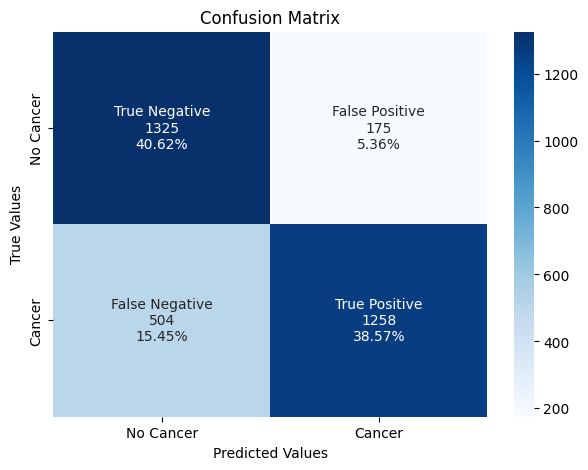

Training the model


Epoch 2, Training: 100%|██████████| 82/82 [00:43<00:00,  1.90batch/s, accuracy=82, loss=0.00471]  


Training metrics for Epoch 2:
Accuracy: 0.8201747662118657
ROC: 0.8277003674654385
Precision: 0.7490774907749077
Recall: 0.9012978142076503
F1 score: 0.8181677259339637
Train loss: 0.0047
Confusion Matrix for training epoch 2: TP: 2639, FP: 289, FN: 884, TN: 2711
Validating the trained model's performance


Validation 2: 100%|██████████| 41/41 [00:06<00:00,  6.19batch/s, accuracy=78.1, loss=0.00574]


Validation metrics for Epoch 2:
Accuracy: 0.7811158798283262
ROC: 0.7880215664018161
Precision: 0.8674614305750351
Recall: 0.7020431328036323
F1 score: 0.7760351317440402
Validation Loss: 0.0057
Confusion Matrix for validation epoch 2: TP: 1237, FP: 189, FN: 525, TN: 1311
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.87      0.70      0.78      1762
   No Cancer       0.71      0.87      0.79      1500

    accuracy                           0.78      3262
   macro avg       0.79      0.79      0.78      3262
weighted avg       0.80      0.78      0.78      3262



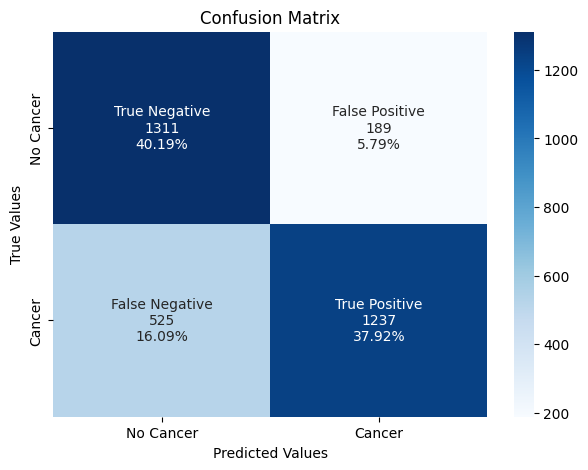

Training the model


Epoch 3, Training: 100%|██████████| 82/82 [00:43<00:00,  1.89batch/s, accuracy=85.2, loss=0.00405]


Training metrics for Epoch 3:
Accuracy: 0.851602023608769
ROC: 0.855205538018359
Precision: 0.7981833664490491
Recall: 0.9162593678722711
F1 score: 0.8531553398058253
Train loss: 0.0041
Confusion Matrix for training epoch 3: TP: 2812, FP: 257, FN: 711, TN: 2743
Validating the trained model's performance


Validation 3: 100%|██████████| 41/41 [00:06<00:00,  6.22batch/s, accuracy=57.1, loss=0.0429]


Validation metrics for Epoch 3:
Accuracy: 0.5708154506437768
ROC: 0.5337794173287931
Precision: 0.5575699745547074
Recall: 0.9948921679909194
F1 score: 0.7146351406441093
Validation Loss: 0.0429
Confusion Matrix for validation epoch 3: TP: 1753, FP: 1391, FN: 9, TN: 109
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.56      0.99      0.71      1762
   No Cancer       0.92      0.07      0.13      1500

    accuracy                           0.57      3262
   macro avg       0.74      0.53      0.42      3262
weighted avg       0.73      0.57      0.45      3262



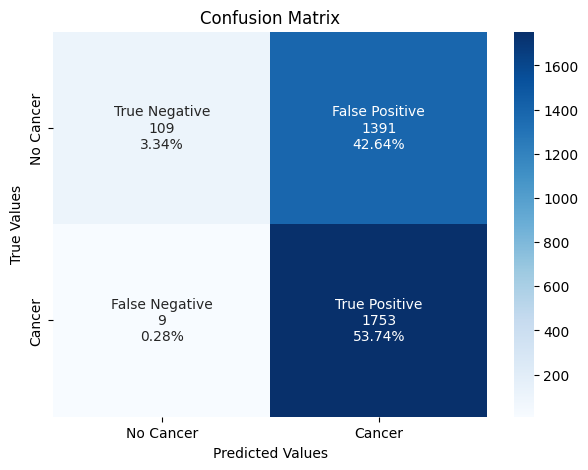

Training the model


Epoch 4, Training: 100%|██████████| 82/82 [00:43<00:00,  1.90batch/s, accuracy=89.2, loss=0.0032] 


Training metrics for Epoch 4:
Accuracy: 0.8917675915989576
ROC: 0.8925146027702338
Precision: 0.8552370139086006
Recall: 0.938921782486756
F1 score: 0.8951277480689245
Train loss: 0.0032
Confusion Matrix for training epoch 4: TP: 3013, FP: 196, FN: 510, TN: 2804
Validating the trained model's performance


Validation 4: 100%|██████████| 41/41 [00:06<00:00,  6.20batch/s, accuracy=77.9, loss=0.0077] 


Validation metrics for Epoch 4:
Accuracy: 0.778969957081545
ROC: 0.7857873628452516
Precision: 0.8642407277816655
Recall: 0.7009080590238366
F1 score: 0.7740520213099342
Validation Loss: 0.0077
Confusion Matrix for validation epoch 4: TP: 1235, FP: 194, FN: 527, TN: 1306
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.86      0.70      0.77      1762
   No Cancer       0.71      0.87      0.78      1500

    accuracy                           0.78      3262
   macro avg       0.79      0.79      0.78      3262
weighted avg       0.79      0.78      0.78      3262



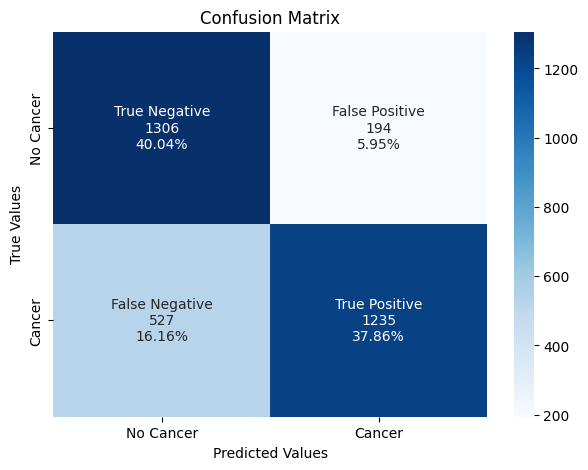

Early stopping inside the current folder!
Finished Training for Fold 1
The best model performance in fold 1 - Val Acc: 0.7790 Precision: 0.8642 Recall: 0.7009 F1: 0.7875 ROC: 0.7858
---------- Fold: 2 ----------
Dimensions of train_data: (6523, 10)
Dimensions of valid_data: (3262, 10)
Class Cancer: Training instances - 3523, Validation instances - 1762
Class No Cancer: Training instances - 3000, Validation instances - 1500
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Directory created for Fold 2: /kaggle/working/Best Model/Fold_2
Training the model


Epoch 1, Training: 100%|██████████| 82/82 [00:43<00:00,  1.90batch/s, accuracy=85.8, loss=0.00392]


Training metrics for Epoch 1:
Accuracy: 0.8577341713935306
ROC: 0.8582276785084688
Precision: 0.8260005676979847
Recall: 0.9023255813953488
F1 score: 0.8624777711914642
Train loss: 0.0039
Confusion Matrix for training epoch 1: TP: 2910, FP: 315, FN: 613, TN: 2685
Validating the trained model's performance


Validation 1: 100%|██████████| 41/41 [00:06<00:00,  6.21batch/s, accuracy=82.3, loss=0.00995]


Validation metrics for Epoch 1:
Accuracy: 0.8228080931943593
ROC: 0.8328592508513053
Precision: 0.9519083969465649
Recall: 0.7077185017026106
F1 score: 0.8118489583333333
Validation Loss: 0.0099
Confusion Matrix for validation epoch 1: TP: 1247, FP: 63, FN: 515, TN: 1437
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.95      0.71      0.81      1762
   No Cancer       0.74      0.96      0.83      1500

    accuracy                           0.82      3262
   macro avg       0.84      0.83      0.82      3262
weighted avg       0.85      0.82      0.82      3262



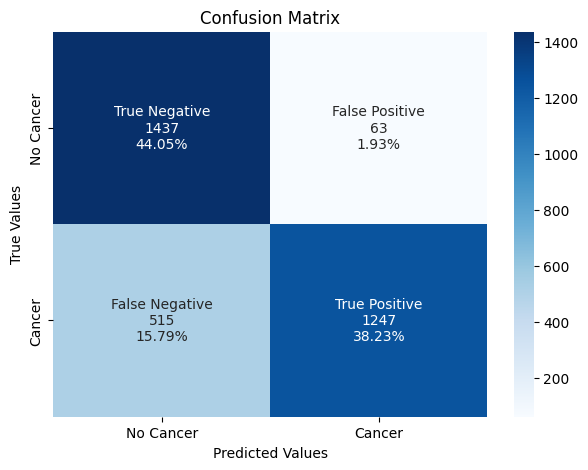

Training the model


Epoch 2, Training: 100%|██████████| 82/82 [00:43<00:00,  1.90batch/s, accuracy=91.4, loss=0.00253]


Training metrics for Epoch 2:
Accuracy: 0.9138433236240994
ROC: 0.9130651156953622
Precision: 0.8955435708203235
Recall: 0.9420722603762317
F1 score: 0.9182188591385332
Train loss: 0.0025
Confusion Matrix for training epoch 2: TP: 3155, FP: 194, FN: 368, TN: 2806
Validating the trained model's performance


Validation 2: 100%|██████████| 41/41 [00:06<00:00,  6.16batch/s, accuracy=88.4, loss=0.00374]


Validation metrics for Epoch 2:
Accuracy: 0.8835070508890251
ROC: 0.8845349981082103
Precision: 0.9088757396449704
Recall: 0.8717366628830874
F1 score: 0.8899188876013906
Validation Loss: 0.0037
Confusion Matrix for validation epoch 2: TP: 1536, FP: 154, FN: 226, TN: 1346
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.91      0.87      0.89      1762
   No Cancer       0.86      0.90      0.88      1500

    accuracy                           0.88      3262
   macro avg       0.88      0.88      0.88      3262
weighted avg       0.88      0.88      0.88      3262



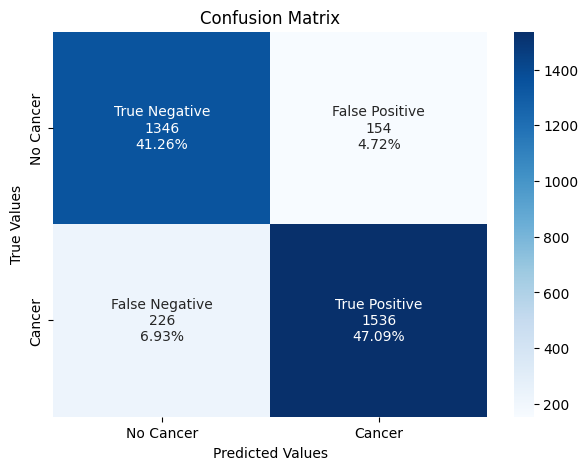

Training the model


Epoch 3, Training: 100%|██████████| 82/82 [00:43<00:00,  1.90batch/s, accuracy=94.6, loss=0.00168]


Training metrics for Epoch 3:
Accuracy: 0.9464970105779549
ROC: 0.9456687276277254
Precision: 0.9401078626170877
Recall: 0.96
F1 score: 0.9499498063960992
Train loss: 0.0017
Confusion Matrix for training epoch 3: TP: 3312, FP: 138, FN: 211, TN: 2862
Validating the trained model's performance


Validation 3: 100%|██████████| 41/41 [00:06<00:00,  6.17batch/s, accuracy=86.1, loss=0.00667]


Validation metrics for Epoch 3:
Accuracy: 0.8608215818516247
ROC: 0.8629909194097617
Precision: 0.8992673992673993
Recall: 0.8359818388195233
F1 score: 0.8664705882352941
Validation Loss: 0.0067
Confusion Matrix for validation epoch 3: TP: 1473, FP: 165, FN: 289, TN: 1335
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.90      0.84      0.87      1762
   No Cancer       0.82      0.89      0.85      1500

    accuracy                           0.86      3262
   macro avg       0.86      0.86      0.86      3262
weighted avg       0.86      0.86      0.86      3262



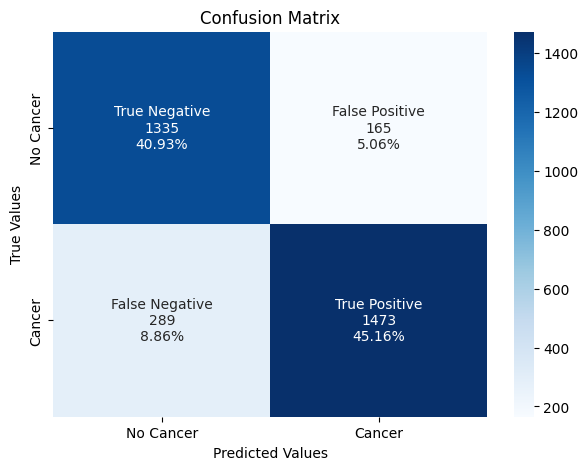

Training the model


Epoch 4, Training: 100%|██████████| 82/82 [00:43<00:00,  1.90batch/s, accuracy=95.1, loss=0.00155]


Training metrics for Epoch 4:
Accuracy: 0.9512494251111452
ROC: 0.9504407972779629
Precision: 0.9446494464944649
Recall: 0.9643581570559259
F1 score: 0.9544020648121594
Train loss: 0.0015
Confusion Matrix for training epoch 4: TP: 3328, FP: 123, FN: 195, TN: 2877
Validating the trained model's performance


Validation 4: 100%|██████████| 41/41 [00:06<00:00,  6.17batch/s, accuracy=81.1, loss=0.00801]


Validation metrics for Epoch 4:
Accuracy: 0.811465358675659
ROC: 0.8009973514945139
Precision: 0.7686182669789228
Recall: 0.9313280363223609
F1 score: 0.8421862971516552
Validation Loss: 0.0080
Confusion Matrix for validation epoch 4: TP: 1641, FP: 494, FN: 121, TN: 1006
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.77      0.93      0.84      1762
   No Cancer       0.89      0.67      0.77      1500

    accuracy                           0.81      3262
   macro avg       0.83      0.80      0.80      3262
weighted avg       0.83      0.81      0.81      3262



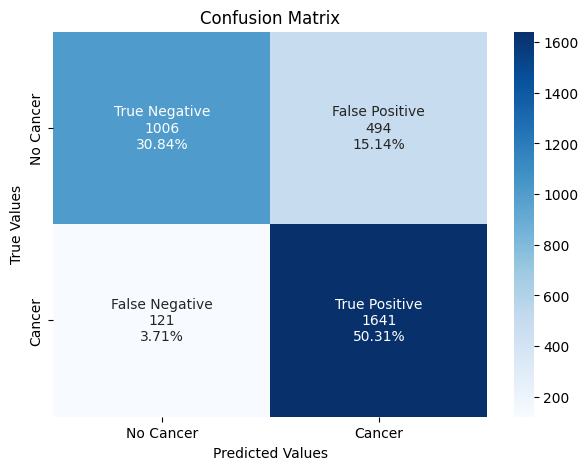

Training the model


Epoch 5, Training: 100%|██████████| 82/82 [00:43<00:00,  1.89batch/s, accuracy=96.2, loss=0.00124]


Training metrics for Epoch 5:
Accuracy: 0.9624405948183351
ROC: 0.9619462688586853
Precision: 0.9613965370422936
Recall: 0.9688215102974829
F1 score: 0.9650947428408605
Train loss: 0.0012
Confusion Matrix for training epoch 5: TP: 3387, FP: 109, FN: 136, TN: 2891
Validating the trained model's performance


Validation 5: 100%|██████████| 41/41 [00:06<00:00,  6.12batch/s, accuracy=86.8, loss=0.005]  


Validation metrics for Epoch 5:
Accuracy: 0.8681790312691601
ROC: 0.869950056753689
Precision: 0.9021739130434783
Recall: 0.8479001135073779
F1 score: 0.8741954359274429
Validation Loss: 0.0050
Confusion Matrix for validation epoch 5: TP: 1494, FP: 162, FN: 268, TN: 1338
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.90      0.85      0.87      1762
   No Cancer       0.83      0.89      0.86      1500

    accuracy                           0.87      3262
   macro avg       0.87      0.87      0.87      3262
weighted avg       0.87      0.87      0.87      3262



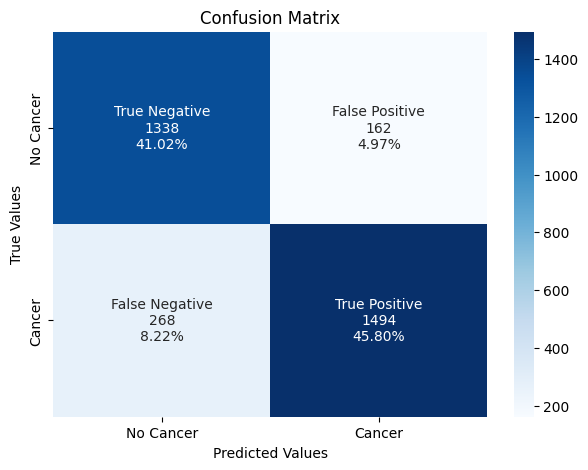

Early stopping inside the current folder!
Finished Training for Fold 2
The best model performance in fold 2 - Val Acc: 0.8682 Precision: 0.9022 Recall: 0.8479 F1: 0.8899 ROC: 0.8700
---------- Fold: 3 ----------
Dimensions of train_data: (6524, 10)
Dimensions of valid_data: (3261, 10)
Class Cancer: Training instances - 3524, Validation instances - 1761
Class No Cancer: Training instances - 3000, Validation instances - 1500
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Directory created for Fold 3: /kaggle/working/Best Model/Fold_3
Training the model


Epoch 1, Training: 100%|██████████| 82/82 [00:43<00:00,  1.88batch/s, accuracy=92.3, loss=0.00259]


Training metrics for Epoch 1:
Accuracy: 0.9233599019006744
ROC: 0.9226174355270681
Precision: 0.9035187287173666
Recall: 0.9521531100478469
F1 score: 0.9271986022131625
Train loss: 0.0026
Confusion Matrix for training epoch 1: TP: 3184, FP: 160, FN: 340, TN: 2840
Validating the trained model's performance


Validation 1: 100%|██████████| 41/41 [00:06<00:00,  6.13batch/s, accuracy=96.3, loss=0.00122]


Validation metrics for Epoch 1:
Accuracy: 0.9628948175406317
ROC: 0.9650516751845541
Precision: 0.9927884615384616
Recall: 0.9381033503691084
F1 score: 0.9646715328467154
Validation Loss: 0.0012
Confusion Matrix for validation epoch 1: TP: 1652, FP: 12, FN: 109, TN: 1488
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.94      0.96      1761
   No Cancer       0.93      0.99      0.96      1500

    accuracy                           0.96      3261
   macro avg       0.96      0.97      0.96      3261
weighted avg       0.96      0.96      0.96      3261



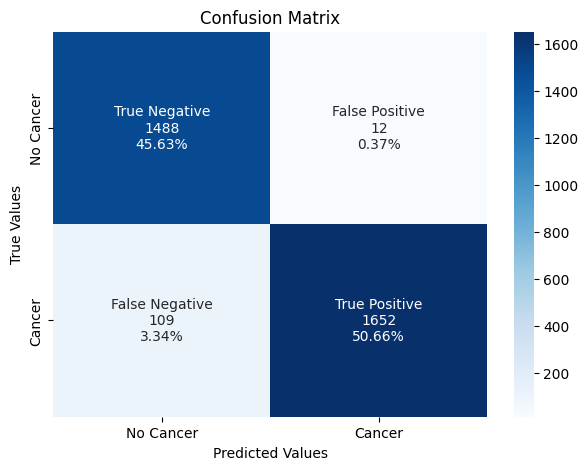

Training the model


Epoch 2, Training: 100%|██████████| 82/82 [00:43<00:00,  1.89batch/s, accuracy=97.1, loss=0.00104]


Training metrics for Epoch 2:
Accuracy: 0.971030042918455
ROC: 0.9703003141918226
Precision: 0.9633938706015891
Recall: 0.9826338639652678
F1 score: 0.9729187562688064
Train loss: 0.0010
Confusion Matrix for training epoch 2: TP: 3395, FP: 60, FN: 129, TN: 2940
Validating the trained model's performance


Validation 2: 100%|██████████| 41/41 [00:06<00:00,  6.14batch/s, accuracy=96.5, loss=0.00106]


Validation metrics for Epoch 2:
Accuracy: 0.9647347439435756
ROC: 0.9654213515048268
Precision: 0.9773781902552204
Recall: 0.9568427030096536
F1 score: 0.9670014347202296
Validation Loss: 0.0011
Confusion Matrix for validation epoch 2: TP: 1685, FP: 39, FN: 76, TN: 1461
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.96      0.97      1761
   No Cancer       0.95      0.97      0.96      1500

    accuracy                           0.96      3261
   macro avg       0.96      0.97      0.96      3261
weighted avg       0.97      0.96      0.96      3261



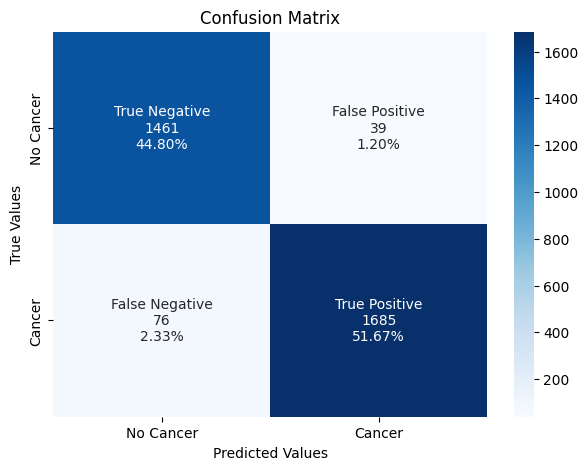

Training the model


Epoch 3, Training: 100%|██████████| 82/82 [00:43<00:00,  1.89batch/s, accuracy=98.4, loss=0.000552]


Training metrics for Epoch 3:
Accuracy: 0.9837522992029429
ROC: 0.9834733568440759
Precision: 0.9826901248581158
Recall: 0.9871721778791334
F1 score: 0.9849260523321958
Train loss: 0.0006
Confusion Matrix for training epoch 3: TP: 3463, FP: 45, FN: 61, TN: 2955
Validating the trained model's performance


Validation 3: 100%|██████████| 41/41 [00:06<00:00,  6.20batch/s, accuracy=94.9, loss=0.00203]


Validation metrics for Epoch 3:
Accuracy: 0.9490953695185526
ROC: 0.9478285065303804
Precision: 0.943301834352418
Recall: 0.9636570130607609
F1 score: 0.9533707865168539
Validation Loss: 0.0020
Confusion Matrix for validation epoch 3: TP: 1697, FP: 102, FN: 64, TN: 1398
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.94      0.96      0.95      1761
   No Cancer       0.96      0.93      0.94      1500

    accuracy                           0.95      3261
   macro avg       0.95      0.95      0.95      3261
weighted avg       0.95      0.95      0.95      3261



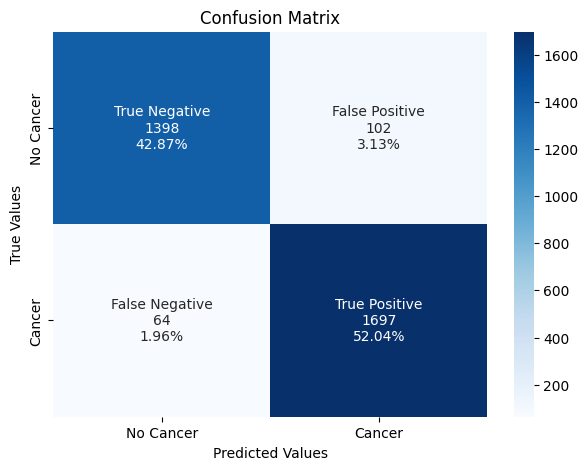

Training the model


Epoch 4, Training: 100%|██████████| 82/82 [00:43<00:00,  1.90batch/s, accuracy=98.4, loss=0.000537]


Training metrics for Epoch 4:
Accuracy: 0.9843654199877376
ROC: 0.9841524268375006
Precision: 0.9841089670828603
Recall: 0.9869095048377917
F1 score: 0.9855072463768115
Train loss: 0.0005
Confusion Matrix for training epoch 4: TP: 3468, FP: 46, FN: 56, TN: 2954
Validating the trained model's performance


Validation 4: 100%|██████████| 41/41 [00:06<00:00,  6.18batch/s, accuracy=94.3, loss=0.00258]


Validation metrics for Epoch 4:
Accuracy: 0.942655627108249
ROC: 0.9434963089153889
Precision: 0.959696261682243
Recall: 0.9329926178307779
F1 score: 0.9461560610423266
Validation Loss: 0.0026
Confusion Matrix for validation epoch 4: TP: 1643, FP: 69, FN: 118, TN: 1431
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.96      0.93      0.95      1761
   No Cancer       0.92      0.95      0.94      1500

    accuracy                           0.94      3261
   macro avg       0.94      0.94      0.94      3261
weighted avg       0.94      0.94      0.94      3261



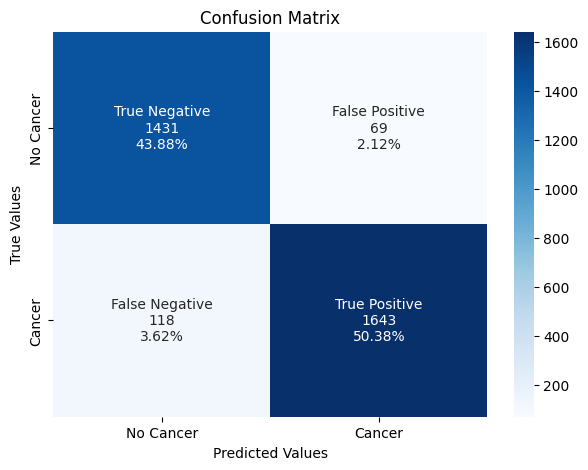

Training the model


Epoch 5, Training: 100%|██████████| 82/82 [00:43<00:00,  1.89batch/s, accuracy=98.1, loss=0.000623]


Training metrics for Epoch 5:
Accuracy: 0.9814530962599632
ROC: 0.9810747816967776
Precision: 0.9792849035187288
Recall: 0.9862817947985139
F1 score: 0.9827708956286488
Train loss: 0.0006
Confusion Matrix for training epoch 5: TP: 3451, FP: 48, FN: 73, TN: 2952
Validating the trained model's performance


Validation 5: 100%|██████████| 41/41 [00:06<00:00,  6.14batch/s, accuracy=94.9, loss=0.00201]


Validation metrics for Epoch 5:
Accuracy: 0.948788715118062
ROC: 0.9497677455990914
Precision: 0.9666276346604216
Recall: 0.9375354911981828
F1 score: 0.9518593254540213
Validation Loss: 0.0020
Confusion Matrix for validation epoch 5: TP: 1651, FP: 57, FN: 110, TN: 1443
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.97      0.94      0.95      1761
   No Cancer       0.93      0.96      0.95      1500

    accuracy                           0.95      3261
   macro avg       0.95      0.95      0.95      3261
weighted avg       0.95      0.95      0.95      3261



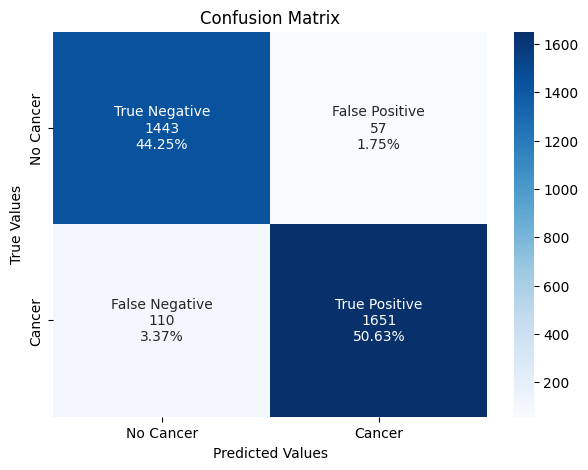

Early stopping inside the current folder!
Finished Training for Fold 3
The best model performance in fold 3 - Val Acc: 0.9488 Precision: 0.9666 Recall: 0.9375 F1: 0.9670 ROC: 0.9498
The overall best model has been saved with metrics - Val Acc: 0.9488, Precision: 0.9666, Recall: 0.9375, F1: 0.9670, ROC: 0.9498
Log file at /kaggle/working/Logs/logs_3.0.txt has been closed.


In [54]:
FOLDS = 3
EPOCHS = 10
PATIENCE = 3
WORKERS = 10

version = '3.0'

# Configuration of hyperparameters
train_batch_size = 80 #64
test_batch_size = 32 #32
val_batch_size = 80 #32
num_workers = 4

# Configuration des hyperparamètres
learning_rate = 0.001
num_epochs = 10
early_stopping_patience = 3
best_model_state = None


base_path = save_best_model_dir  

# Create a dictionary to store the hyperparameters
model_EffNetNetwork = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

train_folds(model=model_EffNetNetwork, train_original=processed_df)

In [ ]:
FOLDS = 3
EPOCHS = 10
PATIENCE = 3
WORKERS = 10

version = '3.0'

# Configuration of hyperparameters
train_batch_size = 80 #64
test_batch_size = 32 #32
val_batch_size = 80 #32
num_workers = 4

# Configuration des hyperparamètres
learning_rate = 0.001
num_epochs = 10
early_stopping_patience = 3
best_model_state = None


base_path = save_best_model_dir  

# Create a dictionary to store the hyperparameters
model_EffNetNetwork = OptimizedEffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

train_folds(model=model_EffNetNetwork, train_original=processed_df)

XceptionNetwork

In [ ]:
from torchvision.models import xception
import torch.nn as nn
import torch.nn.functional as F
import torch

class XceptionNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = xception(weights='IMAGENET1K_V1')
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(2048 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = F.adaptive_avg_pool2d(image, (1, 1)).reshape(-1, 2048)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


LeNetNetwork

In [ ]:
class LeNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(16*5*5 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = image.view(-1, 16*5*5)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


InceptionV3Network

In [ ]:
from torchvision.models import inception_v3

class InceptionV3Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = inception_v3(weights='IMAGENET1K_V1', aux_logits=False)
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(2048 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = F.adaptive_avg_pool2d(image, (1, 1)).reshape(-1, 2048)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


VGG16Network

In [ ]:
from torchvision.models import vgg16

class VGG16Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = vgg16(weights='IMAGENET1K_V1').features
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(512*7*7 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = F.adaptive_avg_pool2d(image, (7, 7)).reshape(-1, 512*7*7)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


InceptionV3Network

In [ ]:
from torchvision.models import mobilenet_v3_large

class MobileNetV3Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = mobilenet_v3_large(weights='IMAGENET1K_V1').features
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(960 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = F.adaptive_avg_pool2d(image, (1, 1)).reshape(-1, 960)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


In [ ]:
import numpy as np
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt

def apply_and_visualize_transformations(img_path, transformations):
    """
    Applies a list of transformations to an image and visualizes the results.
    
    Parameters:
    - img_path: Path to the image file.
    - transformations: List of albumentations.Compose transformations.
    """
    # Load and prepare the image
    img = Image.open(img_path)
    img = np.asarray(img)

    # Calculate the number of rows needed
    num_transformations = len(transformations)
    num_rows = num_transformations
    num_cols = 2  # Original and transformed image

    # Create a figure to display the images
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, num_rows * 5))
    axs = axs.flatten()

    # Iterate over each transformation and its index
    for i, transformation in enumerate(transformations):
        transformed_img = transformation(image=img)['image']
        
        # Display the original image
        axs[i * 2].imshow(img)
        axs[i * 2].set_title(f'Original Image')
        axs[i * 2].axis('off')

        # Display the transformed image
        axs[i * 2 + 1].imshow(transformed_img)
        axs[i * 2 + 1].set_title(f'Transformed Image {i + 1}')
        axs[i * 2 + 1].axis('off')

    # Hide any extra axes if the number of transformations is less than the maximum possible rows
    for j in range(num_transformations * num_cols, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
# Définir les transformations avec albumentations
height, width = 256, 256

#Liste de transformations
#transform1 = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)])
#transform2 = A.Compose([A.RandomRotate90(p=0.5), A.Transpose(p=0.5), A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75), A.Blur(blur_limit=3, p=0.2), A.OpticalDistortion(p=0.3), A.GridDistortion(p=0.3), A.HueSaturationValue(p=0.3)])
#transform3 = A.Compose([A.SmallestMaxSize(max_size=160), A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7), A.RandomCrop(height=128, width=128), A.RandomBrightnessContrast(p=0.5)])
#transform4 = A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)])
#transform5 = A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5), A.InvertImg(p=0.5)])
#transform6 = A.Compose([A.Equalize(p=0.5), A.GaussNoise(var_limit=(10.0, 50.0), p=0.5), A.ISONoise(p=0.5)])
#transform7 = A.Compose([A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5), A.RandomFog(fog_coef_lower=0.05, fog_coef_upper=0.15, alpha_coef=0.05, p=0.3)])
#transform8 = A.Compose([A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.1, p=0.5), A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, p=0.5), A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8, p=0.5)])
#transform9 = A.Compose([A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5), A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5)])
#transform10 = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomBrightnessContrast(p=0.5)])

# Define a specific list of transformations to apply
custom_transformations = [
    A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)]),
    A.Compose([A.RandomRotate90(p=0.5), A.Transpose(p=0.5), A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5)]),
    A.Compose([A.RandomCrop(width=256, height=256),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.2)]),
    A.Compose([A.RandomRotate90(p=0.5),A.Transpose(p=0.5),A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
    A.Compose([A.RandomCrop(height=234, width=234, p=0.5), A.Resize(height, width, p=1.0)]),
    A.Compose([A.CenterCrop(height=200, width=200, p=0.5), A.Resize(height, width, p=1.0)]),
    A.Compose([A.HorizontalFlip(p=0.9), A.VerticalFlip(p=0.7)]),
    A.Compose([A.HorizontalFlip(p=0.4), A.VerticalFlip(p=0.3), A.RandomBrightnessContrast(p=0.1)])
]

# Define a specific list of transformations to apply
custom_transformations = [
    A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)]),
    A.Compose([A.RandomRotate90(p=0.5), A.Transpose(p=0.5), A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5)]),
    A.Compose([A.RandomCrop(width=256, height=256),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.2)]),
    A.Compose([A.RandomRotate90(p=0.9),A.Transpose(p=0.7),A.ShiftScaleRotate(shift_limit=0.0825, scale_limit=0.60, rotate_limit=66, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
    A.Compose([A.HorizontalFlip(p=0.7), A.VerticalFlip(p=0.3)]),
    A.Compose([A.RandomRotate90(p=0.8), A.Transpose(p=0.6), A.ShiftScaleRotate(shift_limit=0.00345, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.07, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=3, p=0.5), A.Sharpen(p=0.45), A.Emboss(p=0.78)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=80, alpha_affine=60, p=0.5), A.RandomGamma(gamma_limit=(90, 130), p=0.7)]),
    A.Compose([A.RandomCrop(width=width, height=height),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.3)]),
    A.Compose([A.RandomRotate90(p=0.5),A.Transpose(p=0.5),A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
]

custom_transformations = [
    A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)]),
    A.Compose([A.RandomRotate90(p=0.5), A.Transpose(p=0.5), A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5)]),
    A.Compose([A.RandomCrop(width=width, height=height),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.2)]),
    A.Compose([A.RandomRotate90(p=0.9),A.Transpose(p=0.7),A.ShiftScaleRotate(shift_limit=0.0825, scale_limit=0.60, rotate_limit=66, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
    A.Compose([A.HorizontalFlip(p=0.7), A.VerticalFlip(p=0.3)]),
    A.Compose([A.RandomRotate90(p=0.8), A.Transpose(p=0.6), A.ShiftScaleRotate(shift_limit=0.00345, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.07, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=3, p=0.5), A.Sharpen(p=0.45), A.Emboss(p=0.78)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=80, alpha_affine=60, p=0.5), A.RandomGamma(gamma_limit=(90, 130), p=0.7)]),
    A.Compose([A.RandomCrop(width=width, height=height),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.3)]),
    A.Compose([A.RandomRotate90(p=0.3),A.Transpose(p=0.45),A.ShiftScaleRotate(shift_limit=0.0725, scale_limit=0.60)]),
    A.Compose([A.RandomRotate90(p=0.7),A.Transpose(p=0.67),A.ShiftScaleRotate(shift_limit=0.0005, scale_limit=0.50, rotate_limit=45, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)])
]